 # Report on the two subsets of  iNaturalist  dataset machine learning image classification with use of CNN method and Autoencoders metods and their comparisement

**Name**: \[ADAM PITLIVKA\]
|
**PI**: \[F8931242\]

# SETUP

In [74]:
import os
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import optimizers
optimizers.RMSprop
import tensorflow_datasets as tfds
optimizers.Adam
optimizers.Adadelta
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import  optimizers
from keras import regularizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import sklearn.metrics
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras import Sequential, optimizers, metrics, layers
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils
import json
import pandas
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import sklearn.metrics
import collections
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
#import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report
from matplotlib.pyplot import subplots
from sklearn import svm
from sklearn.svm import SVC
svc = SVC()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [75]:
!ls /datasets/inat2017/*train.json

/datasets/inat2017/all_train.json
/datasets/inat2017/aves_train.json
/datasets/inat2017/filtered_confusing_species_train.json
/datasets/inat2017/filtered_species_train.json
/datasets/inat2017/most_common_aves_train.json
/datasets/inat2017/most_common_not_aves_train.json
/datasets/inat2017/most_common_train.json
/datasets/inat2017/not_aves_train.json


In [76]:
# Loading the datasets and setting up the image size:

base_dir = '/datasets/inat2017/'
img_dir = os.path.join(base_dir, 'boxed_images')
BATCH_SIZE = 65

IMAGE_SIZE =  (75, 75, 3)
IMAGE_RESCALE = (IMAGE_SIZE[0], IMAGE_SIZE[1])

IMAGE_SIZE

(75, 75, 3)

In [77]:
# Setting up some variables for the training:

epochs = 50
inChannel = 3
x, y = 75, 75
input_img = Input(shape = (x, y, inChannel))

input_img,

(<KerasTensor: shape=(None, 75, 75, 3) dtype=float32 (created by layer 'input_3')>,)

# 1th DATASET  The most_common_not_aves* dataset of the distinct bird species:

## Getting up the dataset data:

In [78]:
with open(os.path.join(base_dir, 'most_common_not_aves_train.json')) as f:
    train_metadata = json.load(f)
train_images = {i['id']: i['file_name'] for i in train_metadata['images']}
len(train_metadata['annotations'])

16472

In [79]:
with open(os.path.join(base_dir, 'most_common_not_aves_validation.json')) as f:
    validation_metadata = json.load(f)
validation_images = {i['id']: i['file_name'] for i in validation_metadata['images']}
len(validation_metadata['annotations'])

2353

In [40]:
with open(os.path.join(base_dir, 'most_common_not_aves_test.json')) as f:
    test_metadata = json.load(f)
test_images = {i['id']: i['file_name'] for i in test_metadata['images']}
len(test_metadata['annotations'])

4706

In [41]:


# number of images in each category
species_counts = collections.Counter(a['category_id'] for a in train_metadata['annotations'])

# The label of each class in the dataset
species_classes = {c['id']: i for i, c in enumerate(train_metadata['categories'])}

# The label of each species
species_lookups = {c: l for l, c in species_classes.items()}

# Number of images in each label
class_counts = {c: species_counts[species_lookups[c]] for c in species_lookups}

# Human-sensible names for each class
class_names = {species_classes[c['id']]: c['name'] for c in train_metadata['categories']}

# Number of classes
classes_num = len(species_counts)

# Weights to use of each class, if necessary
all_image_count = len(train_images)
class_weights = {c: all_image_count / (classes_num * class_counts[c]) 
                for c in class_counts}
# number of images in each supercategory
#top_counts = collections.Counter(
    #species_supercategories[a['category_id']] 
    #for a in train_metadata['annotations'])
    




In [ ]:
# creating list vairable for confusion metrix.
c_names = list(class_names.values())
c_names

## Methods to load images and weights:

In [43]:
def lookup_class_weight(label):
    return class_weights[label.numpy()]


def load_image(image_label):
    image_path = image_label['file_name']
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    # grab the label and encode it
    label = image_label['label']
    encoded_label = tf.one_hot(label, classes_num)
    encoded_label = tf.ensure_shape(encoded_label, [classes_num])
    
    # return the image and the one-hot encoded label
    return image, encoded_label

def load_image_weight(image_label):
    image, encoded_label = load_image(image_label)
    label = image_label['label']
    weight = tf.py_function(lookup_class_weight, inp=[label], Tout=tf.float32)
    tf.ensure_shape(weight, [])

    return image, encoded_label, weight

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    dr = Dropout(0.2)(den)
    out = Dense(10, activation='softmax')(dr)
    return out
#(Autoencoder as a Classifier using Fashion-MNIST Dataset Tutorial, 2018)


def scheduler(epoch, lr):
    return lr * 0.95

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Creating the training, validation and test data:

In [44]:
train_filenames = [(os.path.join(base_dir, train_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in train_metadata['annotations']]
train_filenames, train_labels = zip(*train_filenames)
train_filenames = {'file_name': list(train_filenames), 'label': list(train_labels)}

train_dataset_filenames = tf.data.Dataset.from_tensor_slices(train_filenames)
train_dataset_filenames = train_dataset_filenames.shuffle(10**6)

In [45]:
validation_filenames = [(os.path.join(base_dir, validation_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in validation_metadata['annotations']]
validation_filenames, validation_labels = zip(*validation_filenames)
validation_filenames = {'file_name': list(validation_filenames), 'label': list(validation_labels)}

validation_dataset_filenames = tf.data.Dataset.from_tensor_slices(validation_filenames)

In [46]:
test_filenames = [(os.path.join(base_dir, test_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in test_metadata['annotations']]
test_filenames, test_labels = zip(*test_filenames)
test_filenames = {'file_name': list(test_filenames), 'label': list(test_labels)}

test_dataset_filenames = tf.data.Dataset.from_tensor_slices(test_filenames)

In [48]:
train_dataset = train_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(2000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [49]:
train_dataset_w = train_dataset_filenames.map(load_image_weight, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_w = train_dataset_w.shuffle(2000)
train_dataset_w = train_dataset_w.batch(BATCH_SIZE)
train_dataset_w = train_dataset_w.prefetch(tf.data.AUTOTUNE)

In [50]:
validation_dataset = validation_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [51]:
test_dataset = test_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [52]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape

((65, 75, 75, 3), (65, 10))

In [53]:
# Convert a tdfs mnist element into the form we require for training.
def ds_elem_transform(elem):
    return (tf.cast(elem['image'], tf.float32) / 255, # convert to range 0-1
           tf.one_hot(elem['label'], 10) # one-hot encoding, 10 choices
           )

In [54]:
train_dataset

<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [55]:
jittered_test_labels = np.asarray(
    list(test_dataset
        .flat_map(lambda img, lab: tf.data.Dataset.from_tensor_slices(lab))
        .as_numpy_iterator()                
    ))
jittered_test_labels.shape

(4706, 10)

In [ ]:
jittered_labels = jittered_test_labels + (np.random.random(jittered_test_labels.shape) * 0.8)
jittered_labels

## 1th method (most_common_not_aves*) : CNN deep learning:




### Creating base CNN model:

In [256]:
base_cnn_model = Sequential([

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='valid', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(10, activation='softmax')
                 
])

In [420]:
base_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [421]:
base_cnn_model_history = base_cnn_model.fit(
    train_dataset,
    epochs=20,
    verbose=1,
    validation_data=validation_dataset
)



Epoch 1/20
254/254 [==============================] - 9s 30ms/step - loss: 1.9860 - accuracy: 0.2604 - val_loss: 1.6728 - val_accuracy: 0.3986
Epoch 2/20
254/254 [==============================] - 8s 27ms/step - loss: 1.5324 - accuracy: 0.4747 - val_loss: 1.4142 - val_accuracy: 0.5130
Epoch 3/20
254/254 [==============================] - 8s 27ms/step - loss: 1.2767 - accuracy: 0.5777 - val_loss: 1.0872 - val_accuracy: 0.6464
Epoch 4/20
254/254 [==============================] - 8s 27ms/step - loss: 1.0813 - accuracy: 0.6475 - val_loss: 0.9415 - val_accuracy: 0.7008
Epoch 5/20
254/254 [==============================] - 8s 27ms/step - loss: 0.9338 - accuracy: 0.7000 - val_loss: 0.8774 - val_accuracy: 0.7212
Epoch 6/20
254/254 [==============================] - 8s 27ms/step - loss: 0.8307 - accuracy: 0.7347 - val_loss: 0.7911 - val_accuracy: 0.7344
Epoch 7/20
254/254 [==============================] - 8s 27ms/step - loss: 0.7537 - accuracy: 0.7608 - val_loss: 0.8134 - val_accuracy: 0.7378

In [422]:
base_cnn_model.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 1s 19ms/step - loss: 0.7596 - accuracy: 0.8068


{'loss': 0.7595614790916443, 'accuracy': 0.8068423271179199}

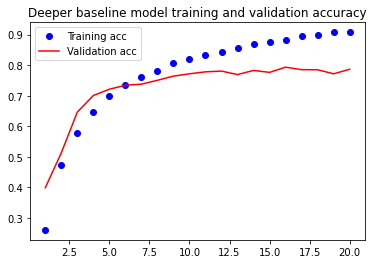

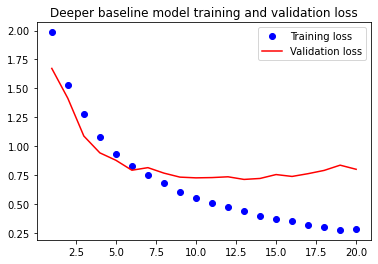

In [424]:
train_acc = base_cnn_model_history.history['accuracy']
val_acc = base_cnn_model_history.history['val_accuracy']
train_loss = base_cnn_model_history.history['loss']
val_loss = base_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Deeper baseline model training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Deeper baseline model training and validation loss')
plt.legend()

In [425]:
base_cnn_model.save('CNN_base_most_common_not_aves.h5')
with open('base_cnn_model_history.json', 'w') as f:
    json.dump(base_cnn_model_history.history, f)

In [26]:
base_cnn_model = tf.keras.models.load_model('CNN_base_most_common_not_aves.h5')


In [ ]:
sample_predictions = base_cnn_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()


# output cleared out to reduce size of the notebook

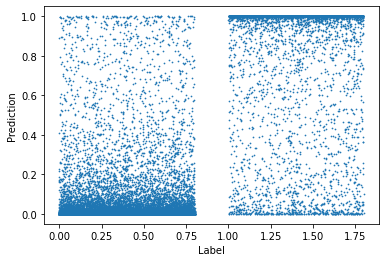

In [27]:
tps = base_cnn_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

### Using residual links and adding more layers on CNN model:

In [513]:
# Building autoencoder mode:
def build_res_model(include_skip=True):
    
    rs_model_input = Input(shape=IMAGE_SIZE)
        
    a = Conv2D(filters=32, kernel_size=(1,1), padding='same',  activation='relu')(rs_model_input)
    b = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(a)
    c = Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(b)
    
    if include_skip:
        ac = Add()([a, c])
    else:
        ac = c

    d = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(ac)
    e = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(d)
    f = Conv2D(filters=64, kernel_size=(1,1), padding='valid', activation='relu')(e)

    if include_skip:
        df = Add()([d, f])
    else:
        df = f
        
    g = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(df)
    h = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(g)
    i = Conv2D(filters=128, kernel_size=(1,1),  padding='valid', activation='relu')(h)

    if include_skip:
        gi = Add()([g, i])
    else:
        gi = i
    
    j = Conv2D(filters=258, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(gi)
    k = Conv2D(filters=258, kernel_size=(3,3), padding='same', activation='relu')(j)
    l = Conv2D(filters=258, kernel_size=(1,1),  padding='valid', activation='relu')(k)
 
    
    if include_skip:
        jl = Add()([j, l])
    else:
        jl = l
    
    
    x = Flatten()(jl)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) 
    x = Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs=rs_model_input, outputs=x, name='build_res_model')

In [514]:
res_no_res_model = build_res_model(include_skip=True)

In [515]:
res_no_res_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [516]:
#training the no res model:
res_no_res_model_history = res_no_res_model.fit(
    train_dataset,
    epochs=20,
    verbose=1,
    validation_data=validation_dataset,
    callbacks=[lr_callback]
)

Epoch 1/20
254/254 [==============================] - 14s 46ms/step - loss: 1.8387 - accuracy: 0.3496 - val_loss: 1.4609 - val_accuracy: 0.5019
Epoch 2/20
254/254 [==============================] - 12s 44ms/step - loss: 1.3843 - accuracy: 0.5365 - val_loss: 1.1720 - val_accuracy: 0.6103
Epoch 3/20
254/254 [==============================] - 12s 44ms/step - loss: 1.1867 - accuracy: 0.6100 - val_loss: 1.0663 - val_accuracy: 0.6519
Epoch 4/20
254/254 [==============================] - 12s 44ms/step - loss: 1.0645 - accuracy: 0.6500 - val_loss: 1.1093 - val_accuracy: 0.6413
Epoch 5/20
254/254 [==============================] - 12s 45ms/step - loss: 0.9628 - accuracy: 0.6826 - val_loss: 0.9231 - val_accuracy: 0.6970
Epoch 6/20
254/254 [==============================] - 12s 45ms/step - loss: 0.8738 - accuracy: 0.7092 - val_loss: 0.8844 - val_accuracy: 0.7182
Epoch 7/20
254/254 [==============================] - 12s 45ms/step - loss: 0.7793 - accuracy: 0.7403 - val_loss: 0.8674 - val_accuracy:

In [304]:
res_no_res_model.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 2s 18ms/step - loss: 1.2018 - accuracy: 0.7599


{'loss': 1.2017582654953003, 'accuracy': 0.7598810195922852}

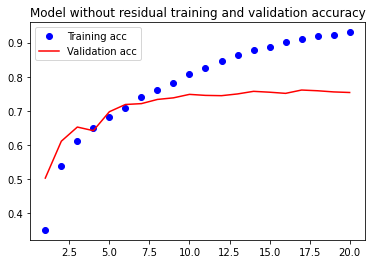

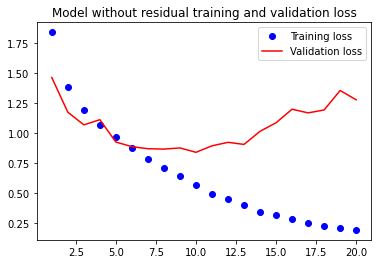

In [518]:
train_acc = res_no_res_model_history.history['accuracy']
val_acc = res_no_res_model_history.history['val_accuracy']
train_loss = res_no_res_model_history.history['loss']
val_loss = res_no_res_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Model without residual training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Model without residual training and validation loss')
plt.legend()

In [551]:
res_no_res_model.save('res_no_res_model_most_common_not_aves.h5')


In [31]:
res_no_res_model = tf.keras.models.load_model('CNN_reslinks_most_common_not_aves.h5')


In [ ]:
sample_predictions = res_no_res_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

# Output cleared to reduce notebooks size

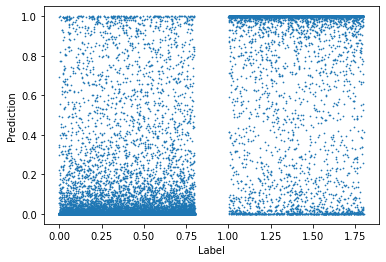

In [32]:
tps = res_no_res_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

### Using augmentation and normalisation on the CNN model :

In [27]:
# Defining of how to agnument data:
# I have used RandomRotation, RandomZoom and RandomFlip.
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2),
    layers.RandomFlip(mode='horizontal')
])

#Agnument the train data:

aug_train_data = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [534]:
agnumented_cnn_model = Sequential([

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='valid', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(10, activation='softmax')
                 
])

In [535]:
agnumented_cnn_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [536]:
agnumented_cnn_model_history = agnumented_cnn_model.fit(aug_train_data,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    )

Epoch 1/100
254/254 [==============================] - 13s 46ms/step - loss: 2.0281 - accuracy: 0.2414 - val_loss: 1.7505 - val_accuracy: 0.3459
Epoch 2/100
254/254 [==============================] - 13s 47ms/step - loss: 1.6773 - accuracy: 0.4041 - val_loss: 1.5713 - val_accuracy: 0.4611
Epoch 3/100
254/254 [==============================] - 12s 46ms/step - loss: 1.4925 - accuracy: 0.4879 - val_loss: 1.4443 - val_accuracy: 0.5104
Epoch 4/100
254/254 [==============================] - 13s 47ms/step - loss: 1.2878 - accuracy: 0.5671 - val_loss: 1.4756 - val_accuracy: 0.5278
Epoch 5/100
254/254 [==============================] - 13s 47ms/step - loss: 1.1827 - accuracy: 0.6030 - val_loss: 1.1729 - val_accuracy: 0.6077
Epoch 6/100
254/254 [==============================] - 12s 46ms/step - loss: 1.0909 - accuracy: 0.6422 - val_loss: 1.2286 - val_accuracy: 0.6116
Epoch 7/100
254/254 [==============================] - 13s 49ms/step - loss: 1.0400 - accuracy: 0.6649 - val_loss: 1.0772 - val_ac

<Figure size 432x288 with 0 Axes>

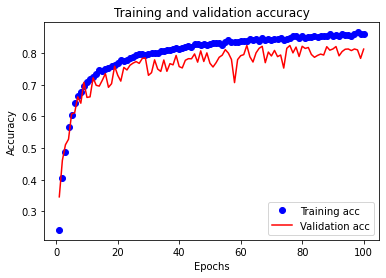

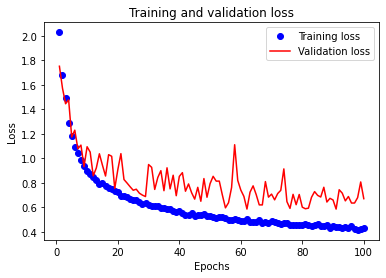

<Figure size 432x288 with 0 Axes>

In [537]:
train_acc = agnumented_cnn_model_history.history['accuracy']
val_acc = agnumented_cnn_model_history.history['val_accuracy']
train_loss = agnumented_cnn_model_history.history['loss']
val_loss = agnumented_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()

In [60]:
agnumented_cnn_model.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 1s 18ms/step - loss: 0.6513 - accuracy: 0.8160


{'loss': 0.6512965559959412, 'accuracy': 0.8159795999526978}

In [548]:
CNN_Agnumented_common_not_aves.save('CNN_Agnumented_common_not_aves.h5')
with open('agnumented_cnn_model_history.json', 'w') as f:
    json.dump(agnumented_cnn_model_history.history, f)

In [59]:
CNN_Agnumented_common_not_aves = tf.keras.models.load_model('CNN_Agnumented_common_not_aves.h5')
with open('agnumented_cnn_model_history.json') as f:
    agnumented_cnn_model_history = json.load(f)

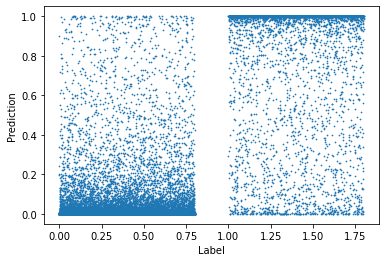

In [61]:
tps = agnumented_cnn_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [235]:
test_predictions = augumented_model.predict(test_dataset)
test_predictions.shape

(4854, 9)

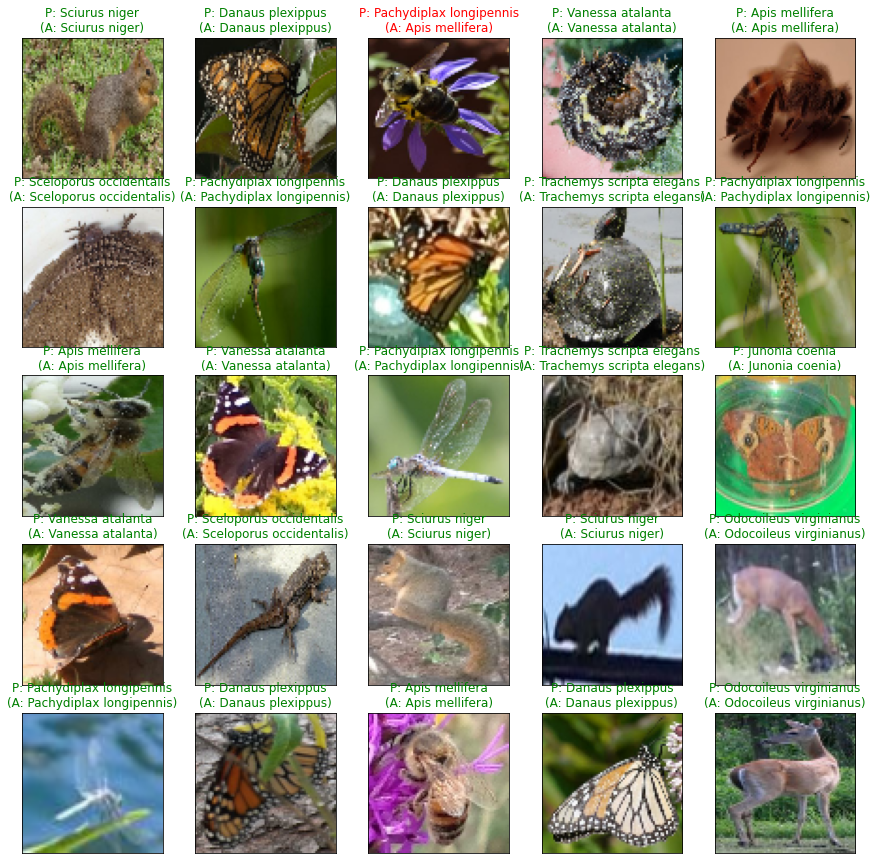

In [540]:
sample_predictions = agnumented_cnn_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

**Adding normmalization layer**

In [23]:
# Adding normalisation layer to the agnumented model:
norm_layer = layers.Normalization(input_shape=IMAGE_SIZE)

norm_agnumented_cnn_model = Sequential([
    
    norm_layer,

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='same', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(10, activation='softmax')
                 
])

In [24]:
norm_agnumented_cnn_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [28]:
norm_agnumented_cnn_model_history = norm_agnumented_cnn_model.fit(aug_train_data,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    )

Epoch 1/100
254/254 [==============================] - 17s 51ms/step - loss: 1.9992 - accuracy: 0.2628 - val_loss: 1.7735 - val_accuracy: 0.3583
Epoch 2/100
254/254 [==============================] - 12s 46ms/step - loss: 1.7351 - accuracy: 0.3711 - val_loss: 1.5737 - val_accuracy: 0.4390
Epoch 3/100
254/254 [==============================] - 12s 46ms/step - loss: 1.5823 - accuracy: 0.4478 - val_loss: 1.3375 - val_accuracy: 0.5512
Epoch 4/100
254/254 [==============================] - 12s 46ms/step - loss: 1.4066 - accuracy: 0.5305 - val_loss: 1.4935 - val_accuracy: 0.5049
Epoch 5/100
254/254 [==============================] - 13s 47ms/step - loss: 1.3015 - accuracy: 0.5699 - val_loss: 1.5905 - val_accuracy: 0.5168
Epoch 6/100
254/254 [==============================] - 12s 46ms/step - loss: 1.1783 - accuracy: 0.6137 - val_loss: 1.2520 - val_accuracy: 0.6073
Epoch 7/100
254/254 [==============================] - 12s 45ms/step - loss: 1.1030 - accuracy: 0.6367 - val_loss: 1.1252 - val_ac

<Figure size 432x288 with 0 Axes>

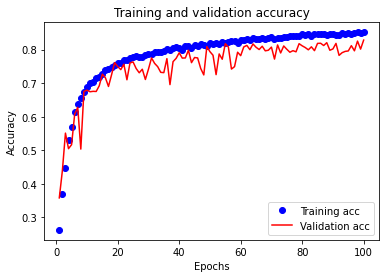

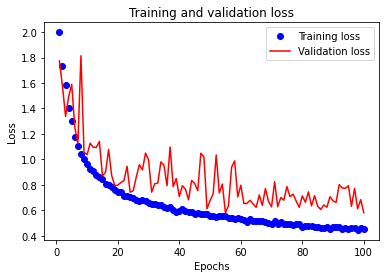

<Figure size 432x288 with 0 Axes>

In [31]:
train_acc = norm_agnumented_cnn_model_history.history['accuracy']
val_acc = norm_agnumented_cnn_model_history.history['val_accuracy']
train_loss = norm_agnumented_cnn_model_history.history['loss']
val_loss = norm_agnumented_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()

In [64]:
norm_agnumented_cnn_model.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 1s 18ms/step - loss: 0.6092 - accuracy: 0.8217


{'loss': 0.6091800928115845, 'accuracy': 0.8217169642448425}

In [29]:
norm_agnumented_cnn_model.save('norm_agnumented_cnn_model.h5')
with open('norm_agnumented_cnn_model_history.json', 'w') as f:
    json.dump(norm_agnumented_cnn_model_history.history, f)

In [63]:
norm_agnumented_cnn_model = tf.keras.models.load_model('CNN_norm_agn_most_common_not_aves.h5')
with open('agnumented_cnn_model_history.json') as f:
    agnumented_cnn_model_history = json.load(f)

In [74]:
test_predictions = norm_agnumented_cnn_model.predict(test_dataset)
test_predictions.shape
  

(4706, 10)

In [69]:
predicted_classes = np.argmax(np.round(test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                           precision    recall  f1-score   support

         Danaus plexippus       0.63      0.94      0.75       809
           Apis mellifera       0.93      0.83      0.88       633
  Sceloporus occidentalis       0.79      0.87      0.82       650
   Odocoileus virginianus       0.92      0.66      0.77       495
Trachemys scripta elegans       0.84      0.79      0.81       408
            Sciurus niger       0.79      0.58      0.67       401
     Sciurus carolinensis       0.64      0.54      0.59       341
  Pachydiplax longipennis       0.94      0.87      0.90       335
           Junonia coenia       0.93      0.84      0.88       320
         Vanessa atalanta       0.96      0.88      0.92       314

                 accuracy                           0.80      4706
                macro avg       0.84      0.78      0.80      4706
             weighted avg       0.82      0.80      0.80      4706



In [75]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(4706,)

In [72]:

predict_labels = np.argmax(test_predictions, axis=1)

In [76]:
# Generatin confusion matrix:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[738  21   4   6  17   4   6   7   4   2]
 [ 16 552  18   3   6  19   8   4   4   3]
 [ 19   4 578   4  16   5  14   3   7   0]
 [  6   9  36 351  12  17  61   0   3   0]
 [  5   4  33   2 339   7  10   6   1   1]
 [  7   9  32  15  15 260  61   1   0   1]
 [  2   6  61  15  15  39 201   0   0   2]
 [  8   2  14   2   7   0   0 297   5   0]
 [ 10   7   5   6   5   3   3   2 274   5]
 [ 15   2   8   1   3   1   1   2   4 277]]


## 2th method (most_common_not_aves*) : Autoencoders image classification





### Training the autoencoder base model:

#### Training the autoencoder  model:

In [25]:
def encoder(input_img):

    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

def decoder(conv4):    
    #decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    x = UpSampling2D((2,2))(x) 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = UpSampling2D((2,2))(x) 
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x) 

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = UpSampling2D((2,2))(x) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x) 
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(10, activation='softmax')(dp4)
    
    return decoded


In [26]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer ='adam')

In [27]:
autoencoder_train = autoencoder.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    epochs=20,
)

Epoch 1/20
254/254 [==============================] - 14s 38ms/step - loss: 0.0788 - val_loss: 0.0850
Epoch 2/20
254/254 [==============================] - 9s 32ms/step - loss: 0.0685 - val_loss: 0.0915
Epoch 3/20
254/254 [==============================] - 9s 32ms/step - loss: 0.0616 - val_loss: 0.0705
Epoch 4/20
254/254 [==============================] - 9s 32ms/step - loss: 0.0539 - val_loss: 0.0930
Epoch 5/20
254/254 [==============================] - 9s 32ms/step - loss: 0.0495 - val_loss: 0.0589
Epoch 6/20
254/254 [==============================] - 9s 32ms/step - loss: 0.0447 - val_loss: 0.0494
Epoch 7/20
254/254 [==============================] - 9s 33ms/step - loss: 0.0425 - val_loss: 0.0558
Epoch 8/20
254/254 [==============================] - 9s 33ms/step - loss: 0.0409 - val_loss: 0.0410
Epoch 9/20
254/254 [==============================] - 9s 33ms/step - loss: 0.0380 - val_loss: 0.0646
Epoch 10/20
254/254 [==============================] - 9s 33ms/step - loss: 0.0366 - val_l

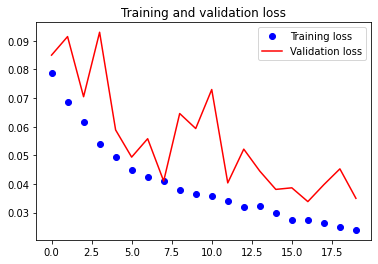

In [29]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
def encoder(input_img):
   
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

In [32]:
# Connecting fully connected layers:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


In [33]:
#Adding weights from autoencoer to new encoder:
for l1,l2 in zip(full_model.layers[:14],autoencoder.layers[0:14]):
    l1.set_weights(l2.get_weights())

In [34]:
#As the layers in autoencoders are already trained , we need to train only the new fully connected layers:
for layer in full_model.layers[0:14]:
    layer.trainable = False

In [35]:
#Compiling the model
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

In [36]:
classify_train = full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=10,verbose=1,validation_data=(validation_dataset))

Epoch 1/10
254/254 [==============================] - 7s 23ms/step - loss: 0.6482 - accuracy: 0.8109 - val_loss: 0.6255 - val_accuracy: 0.7977
Epoch 2/10
254/254 [==============================] - 6s 22ms/step - loss: 0.4807 - accuracy: 0.8558 - val_loss: 0.6182 - val_accuracy: 0.7981
Epoch 3/10
254/254 [==============================] - 6s 22ms/step - loss: 0.4607 - accuracy: 0.8626 - val_loss: 0.6339 - val_accuracy: 0.7909
Epoch 4/10
254/254 [==============================] - 6s 22ms/step - loss: 0.4528 - accuracy: 0.8641 - val_loss: 0.6146 - val_accuracy: 0.8011
Epoch 5/10
254/254 [==============================] - 6s 23ms/step - loss: 0.4440 - accuracy: 0.8711 - val_loss: 0.6118 - val_accuracy: 0.7960
Epoch 6/10
254/254 [==============================] - 6s 23ms/step - loss: 0.4405 - accuracy: 0.8677 - val_loss: 0.6067 - val_accuracy: 0.7998
Epoch 7/10
254/254 [==============================] - 6s 23ms/step - loss: 0.4430 - accuracy: 0.8672 - val_loss: 0.6121 - val_accuracy: 0.7960

In [37]:
for layer in full_model.layers[0:14]:
    layer.trainable = True

In [38]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer= 'Adam',metrics=['accuracy'])

In [39]:
classify_train = full_model.fit(train_dataset, batch_size=64,epochs=20,verbose=1,validation_data=(validation_dataset))

Epoch 1/20
254/254 [==============================] - 8s 28ms/step - loss: 0.4790 - accuracy: 0.8509 - val_loss: 0.7110 - val_accuracy: 0.7748
Epoch 2/20
254/254 [==============================] - 7s 27ms/step - loss: 0.4223 - accuracy: 0.8657 - val_loss: 0.6725 - val_accuracy: 0.7879
Epoch 3/20
254/254 [==============================] - 7s 27ms/step - loss: 0.3743 - accuracy: 0.8833 - val_loss: 0.7059 - val_accuracy: 0.7867
Epoch 4/20
254/254 [==============================] - 8s 27ms/step - loss: 0.3449 - accuracy: 0.8903 - val_loss: 0.6593 - val_accuracy: 0.7969
Epoch 5/20
254/254 [==============================] - 7s 27ms/step - loss: 0.3159 - accuracy: 0.8975 - val_loss: 0.8260 - val_accuracy: 0.7697
Epoch 6/20
254/254 [==============================] - 8s 27ms/step - loss: 0.2889 - accuracy: 0.9066 - val_loss: 0.7243 - val_accuracy: 0.8020
Epoch 7/20
254/254 [==============================] - 7s 27ms/step - loss: 0.2584 - accuracy: 0.9142 - val_loss: 0.8648 - val_accuracy: 0.7680

In [40]:
full_model.save_weights('classification_complete.h5')

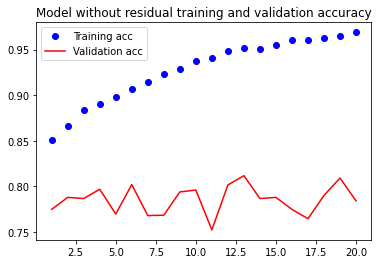

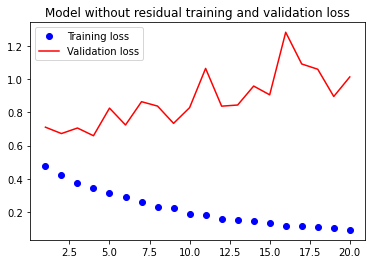

In [41]:
train_acc = classify_train.history['accuracy']
val_acc = classify_train.history['val_accuracy']
train_loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Model without residual training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Model without residual training and validation loss')
plt.legend()

In [61]:
full_model.save('AUTOEN_base_most_common_not_aves.h5')

with open('base_a_model_history.json', 'w') as f:
    json.dump(classify_train.history, f)

In [266]:
base_A_model = tf.keras.models.load_model('AUTOEN_base_most_common_not_aves.h5')
with open('base_a_model_history.json') as f:
    example_history = json.load(f)

#### Evaluating the base models performance:

In [44]:

full_model.evaluate(test_dataset, return_dict=True)


73/73 [==============================] - 1s 20ms/step - loss: 1.0955 - accuracy: 0.7777


{'loss': 1.0955170392990112, 'accuracy': 0.7777305841445923}

In [45]:
base_test_predictions = full_model.predict(test_dataset)
base_test_predictions.shape

(4706, 10)

In [47]:
predict_labels = np.argmax(base_test_predictions, axis=1)
predict_labels.shape

(4706,)

In [48]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(4706,)

In [76]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()

Text(0, 0.5, 'Prediction')

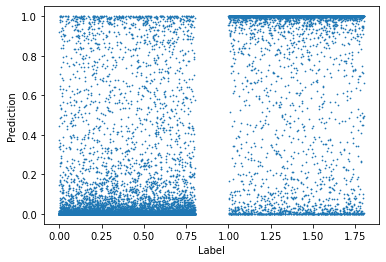

In [50]:
tps = full_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction')

In [53]:
predicted_classes = np.argmax(np.round(base_test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                           precision    recall  f1-score   support

         Danaus plexippus       0.83      0.89      0.86       809
           Apis mellifera       0.92      0.75      0.83       633
  Sceloporus occidentalis       0.79      0.80      0.79       650
   Odocoileus virginianus       0.68      0.82      0.75       495
Trachemys scripta elegans       0.83      0.66      0.73       408
            Sciurus niger       0.64      0.56      0.60       401
     Sciurus carolinensis       0.46      0.64      0.53       341
  Pachydiplax longipennis       0.85      0.88      0.87       335
           Junonia coenia       0.88      0.78      0.83       320
         Vanessa atalanta       0.94      0.83      0.88       314

                 accuracy                           0.77      4706
                macro avg       0.78      0.76      0.77      4706
             weighted avg       0.79      0.77      0.78      4706



In [ ]:
sample_predictions = full_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

### Adding dropout  and normalisation layers:

#### Training the encoder model:

In [79]:
def dropout_encoder(input_img):
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4

def dropout_decoder(conv4): 
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(10, activation='softmax')(dp4)
    
    
    return decoded

In [80]:
dropout_autoencoder = Model(input_img, dropout_decoder(dropout_encoder(input_img)))
dropout_autoencoder.compile(loss='mean_squared_error', optimizer ='Adam')

In [81]:
#Training the normalisation model:
dropout_autoencoder_train = dropout_autoencoder.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    epochs=40,
)

Epoch 1/40
254/254 [==============================] - 13s 42ms/step - loss: 0.1717 - val_loss: 0.1850
Epoch 2/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1770 - val_loss: 0.1839
Epoch 3/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1830 - val_loss: 0.1759
Epoch 4/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1772 - val_loss: 0.1754
Epoch 5/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1732 - val_loss: 0.1655
Epoch 6/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1707 - val_loss: 0.1679
Epoch 7/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1658 - val_loss: 0.1624
Epoch 8/40
254/254 [==============================] - 11s 41ms/step - loss: 0.1697 - val_loss: 0.1697
Epoch 9/40
254/254 [==============================] - 11s 42ms/step - loss: 0.1704 - val_loss: 0.1697
Epoch 10/40
254/254 [==============================] - 11s 41ms/step - loss: 0.170

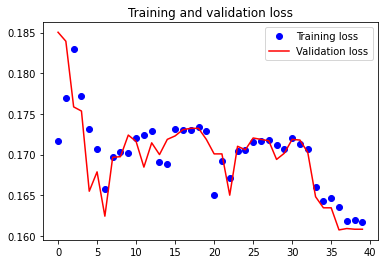

In [82]:
loss = dropout_autoencoder_train.history['loss']
val_loss = dropout_autoencoder_train.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [83]:
dropout_A_model = tf.keras.models.load_model('dropout_a_model.h5')
with open('dropout_a_model.json') as f:
    example_history = json.load(f)

In [84]:
def dropout_encoder(input_img):

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4


In [ ]:
# Mewthod to connect the fully connected layers to the encoder above:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    dr = Dropout(0.2)(den)
    out = Dense(10, activation='softmax')(dr)
    return out


In [86]:

dropout_encode = dropout_encoder(input_img)
dropout_full_model = Model(input_img,fc(dropout_encode))

In [87]:
for l1,l2 in zip(dropout_full_model.layers[:24],dropout_autoencoder.layers[0:24]):
    l1.set_weights(l2.get_weights())

In [88]:
# as the original encoder part is originaly trained, we disable those layers for the training:
for layer in dropout_full_model.layers[0:24]:
    layer.trainable = False


In [89]:
# compaling model:
dropout_full_model.compile(loss='categorical_crossentropy', optimizer ='adam',metrics=['accuracy'])

In [90]:
# Training model :
dropout_classify_train = dropout_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))


Epoch 1/30
254/254 [==============================] - 7s 24ms/step - loss: 2.2160 - accuracy: 0.2060 - val_loss: 2.1143 - val_accuracy: 0.2541
Epoch 2/30
254/254 [==============================] - 7s 23ms/step - loss: 2.1223 - accuracy: 0.2447 - val_loss: 2.0672 - val_accuracy: 0.2656
Epoch 3/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0916 - accuracy: 0.2530 - val_loss: 2.0504 - val_accuracy: 0.2805
Epoch 4/30
254/254 [==============================] - 7s 24ms/step - loss: 2.0727 - accuracy: 0.2618 - val_loss: 2.0559 - val_accuracy: 0.2830
Epoch 5/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0598 - accuracy: 0.2678 - val_loss: 2.0403 - val_accuracy: 0.2711
Epoch 6/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0546 - accuracy: 0.2695 - val_loss: 2.0221 - val_accuracy: 0.2924
Epoch 7/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0399 - accuracy: 0.2725 - val_loss: 2.0312 - val_accuracy: 0.2686

In [91]:
# Re training the model now again with all of the layers enabled for training:
for layer in dropout_full_model.layers[0:24]:
    layer.trainable = True


In [92]:
dropout_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
# Training the model:
dropout_classify_train = dropout_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))

Epoch 1/30
254/254 [==============================] - 9s 31ms/step - loss: 1.7783 - accuracy: 0.3635 - val_loss: 1.6145 - val_accuracy: 0.4258
Epoch 2/30
254/254 [==============================] - 8s 30ms/step - loss: 1.3989 - accuracy: 0.5183 - val_loss: 1.5410 - val_accuracy: 0.4713
Epoch 3/30
254/254 [==============================] - 8s 31ms/step - loss: 1.1886 - accuracy: 0.5925 - val_loss: 1.1545 - val_accuracy: 0.6094
Epoch 4/30
254/254 [==============================] - 8s 31ms/step - loss: 1.0562 - accuracy: 0.6494 - val_loss: 1.1277 - val_accuracy: 0.6383
Epoch 5/30
254/254 [==============================] - 8s 31ms/step - loss: 0.9522 - accuracy: 0.6807 - val_loss: 1.1539 - val_accuracy: 0.6264
Epoch 6/30
254/254 [==============================] - 8s 31ms/step - loss: 0.8694 - accuracy: 0.7129 - val_loss: 1.0021 - val_accuracy: 0.6655
Epoch 7/30
254/254 [==============================] - 8s 31ms/step - loss: 0.7940 - accuracy: 0.7315 - val_loss: 0.8107 - val_accuracy: 0.7255

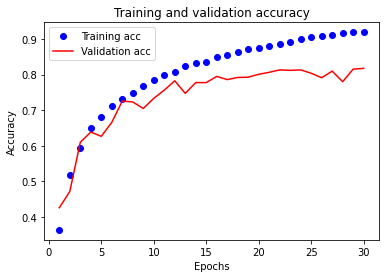

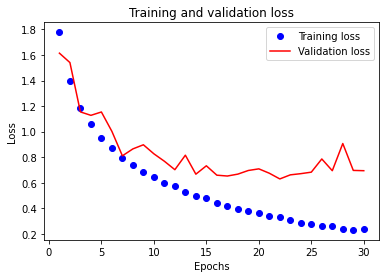

In [94]:
train_acc = dropout_classify_train.history['accuracy']
val_acc = dropout_classify_train.history['val_accuracy']
train_loss = dropout_classify_train.history['loss']
val_loss = dropout_classify_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [95]:
AUTOEN_dropout_most_common_not_aves.save('AUTOEN_dropout_most_common_not_aves.h5')
with open('dropout_a_model.json', 'w') as f:
    json.dump(dropout_classify_train.history, f)

In [77]:
AUTOEN_dropout_most_common_not_aves = tf.keras.models.load_model('AUTOEN_dropout_most_common_not_aves.h5')
with open('dropout_a_model.json') as f:
    example_history = json.load(f)

#### Evaluating the model with added dropout layers:

In [78]:
AUTOEN_dropout_most_common_not_aves.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 2s 18ms/step - loss: 0.7113 - accuracy: 0.8134


{'loss': 0.7112967371940613, 'accuracy': 0.8134296536445618}

In [79]:
test_predictions = AUTOEN_dropout_most_common_not_aves.predict(test_dataset)
test_predictions.shape
  

(4706, 10)

In [80]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

(4706,)

In [81]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(4706,)

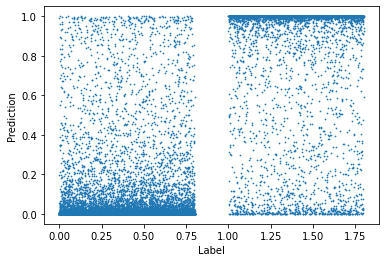

In [82]:
tps = AUTOEN_dropout_most_common_not_aves.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [84]:
predicted_classes = np.argmax(np.round(test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                           precision    recall  f1-score   support

         Danaus plexippus       0.75      0.89      0.81       809
           Apis mellifera       0.91      0.84      0.87       633
  Sceloporus occidentalis       0.74      0.89      0.81       650
   Odocoileus virginianus       0.83      0.80      0.81       495
Trachemys scripta elegans       0.76      0.79      0.77       408
            Sciurus niger       0.80      0.52      0.63       401
     Sciurus carolinensis       0.60      0.65      0.63       341
  Pachydiplax longipennis       0.95      0.84      0.89       335
           Junonia coenia       0.95      0.78      0.86       320
         Vanessa atalanta       0.93      0.87      0.90       314

                 accuracy                           0.80      4706
                macro avg       0.82      0.79      0.80      4706
             weighted avg       0.81      0.80      0.80      4706



In [85]:

predict_labels = np.argmax(test_predictions, axis=1)

In [ ]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)



In [ ]:
sample_predictions = dropout_full_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()
# output cleared to make notebook smaller

### Applying slower learning rate to reduce overfitting:

#### Training the encoder model:

In [3]:
def normalised_encoder(input_img):

    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4

def normalised_decoder(conv4):    
    #decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 

    
  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
   

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(10, activation='softmax')(dp4)
    
    

    return decoded

In [4]:
lr_normalised_autoencoder = Model(input_img, normalised_decoder(normalised_encoder(input_img)))
lr_normalised_autoencoder.compile(loss='mean_squared_error', optimizer ='Adam')

NameError: name 'Model' is not defined

In [24]:
lr_normalised_autoencoder_train = lr_normalised_autoencoder.fit(train_dataset, batch_size=BATCH_SIZE,epochs=20,verbose=1,validation_data=(validation_dataset))

Epoch 1/20
254/254 [==============================] - 26s 79ms/step - loss: 0.1701 - val_loss: 0.1851
Epoch 2/20
254/254 [==============================] - 19s 74ms/step - loss: 0.1777 - val_loss: 0.1813
Epoch 3/20
254/254 [==============================] - 19s 74ms/step - loss: 0.1773 - val_loss: 0.1889
Epoch 4/20
254/254 [==============================] - 19s 74ms/step - loss: 0.1726 - val_loss: 0.1745
Epoch 5/20
254/254 [==============================] - 19s 74ms/step - loss: 0.1755 - val_loss: 0.1820
Epoch 6/20
254/254 [==============================] - 20s 74ms/step - loss: 0.1809 - val_loss: 0.1824
Epoch 7/20
254/254 [==============================] - 20s 75ms/step - loss: 0.1807 - val_loss: 0.1875
Epoch 8/20
254/254 [==============================] - 20s 75ms/step - loss: 0.1790 - val_loss: 0.1797
Epoch 9/20
254/254 [==============================] - 20s 75ms/step - loss: 0.1795 - val_loss: 0.1822
Epoch 10/20
254/254 [==============================] - 20s 75ms/step - loss: 0.176

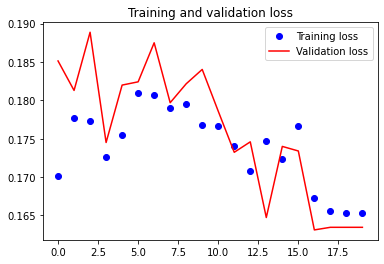

In [25]:
loss = lr_normalised_autoencoder_train.history['loss']
val_loss = lr_normalised_autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
def normalised_encoder(input_img):
   
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4

In [55]:
# connecting fully connected layers:
normalised_encode = normalised_encoder(input_img)
slow_rate_full_model = Model(input_img,fc(normalised_encode))

In [56]:
# Saving weights from autoencodder
for l1,l2 in zip(slow_rate_full_model.layers[:24],lr_normalised_autoencoder.layers[0:24]):
    l1.set_weights(l2.get_weights())

In [57]:
# turning learning for already trained layers off.
for layer in slow_rate_full_model.layers[0:24]:
    layer.trainable = False

In [58]:
slow_rate_full_model.compile(loss='categorical_crossentropy', optimizer ='adam',metrics=['accuracy'])

In [59]:
slow_rate_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
slow_rate_full_model_train = slow_rate_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))



Epoch 1/30
254/254 [==============================] - 8s 25ms/step - loss: 2.2412 - accuracy: 0.1925 - val_loss: 2.1496 - val_accuracy: 0.2308
Epoch 2/30
254/254 [==============================] - 6s 23ms/step - loss: 2.1606 - accuracy: 0.2222 - val_loss: 2.1310 - val_accuracy: 0.2405
Epoch 3/30
254/254 [==============================] - 6s 23ms/step - loss: 2.1296 - accuracy: 0.2358 - val_loss: 2.1241 - val_accuracy: 0.2397
Epoch 4/30
254/254 [==============================] - 6s 23ms/step - loss: 2.1124 - accuracy: 0.2417 - val_loss: 2.1083 - val_accuracy: 0.2529
Epoch 5/30
254/254 [==============================] - 7s 23ms/step - loss: 2.1072 - accuracy: 0.2416 - val_loss: 2.1241 - val_accuracy: 0.2405
Epoch 6/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0974 - accuracy: 0.2468 - val_loss: 2.0881 - val_accuracy: 0.2554
Epoch 7/30
254/254 [==============================] - 6s 23ms/step - loss: 2.0884 - accuracy: 0.2519 - val_loss: 2.1160 - val_accuracy: 0.2482

In [61]:
for layer in slow_rate_full_model.layers[0:24]:
    layer.trainable = True

In [62]:
def scheduler(epoch, lr):
    return lr * 0.95

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [63]:
slow_rate_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), # Lower initial learning rate
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
slow_rate_full_model_train = slow_rate_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset),callbacks=[lr_callback])

Epoch 1/30
254/254 [==============================] - 10s 32ms/step - loss: 1.8178 - accuracy: 0.3583 - val_loss: 2.0097 - val_accuracy: 0.2873
Epoch 2/30
254/254 [==============================] - 9s 31ms/step - loss: 1.5074 - accuracy: 0.4744 - val_loss: 2.7466 - val_accuracy: 0.2563
Epoch 3/30
254/254 [==============================] - 9s 31ms/step - loss: 1.3039 - accuracy: 0.5557 - val_loss: 1.6020 - val_accuracy: 0.4679
Epoch 4/30
254/254 [==============================] - 9s 31ms/step - loss: 1.1565 - accuracy: 0.6101 - val_loss: 1.2762 - val_accuracy: 0.5712
Epoch 5/30
254/254 [==============================] - 9s 31ms/step - loss: 1.0533 - accuracy: 0.6447 - val_loss: 1.5256 - val_accuracy: 0.5159
Epoch 6/30
254/254 [==============================] - 9s 32ms/step - loss: 0.9479 - accuracy: 0.6822 - val_loss: 1.0731 - val_accuracy: 0.6481
Epoch 7/30
254/254 [==============================] - 9s 31ms/step - loss: 0.8821 - accuracy: 0.7053 - val_loss: 1.0634 - val_accuracy: 0.662

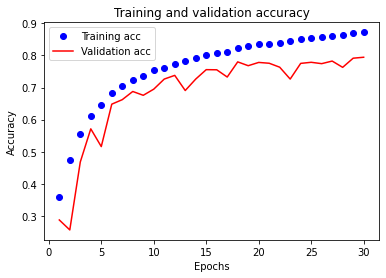

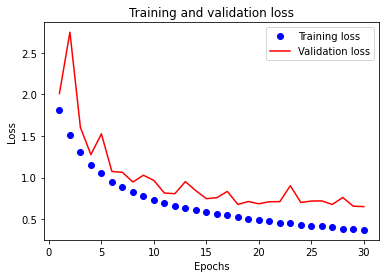

In [65]:
train_acc = slow_rate_full_model_train.history['accuracy']
val_acc = slow_rate_full_model_train.history['val_accuracy']
train_loss = slow_rate_full_model_train.history['loss']
val_loss = slow_rate_full_model_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [66]:
slow_rate_full_model.save('AUTOEN_slowlr_most_common_not_aves.h5')


In [271]:
slow_learning_rate_A_model = tf.keras.models.load_model('AUTOEN_slowlr_most_common_not_aves.h5')


#### Evaluating the slow learning rate model:

In [100]:
slow_learning_rate_A_model.evaluate(test_dataset, return_dict=True)

73/73 [==============================] - 1s 18ms/step - loss: 0.6574 - accuracy: 0.7983


{'loss': 0.6573728919029236, 'accuracy': 0.7983425259590149}

In [69]:
test_predictions = slow_rate_full_model.predict(test_dataset)
test_predictions.shape
  

(4706, 10)

In [338]:
slow_predicted_classes = slow_learning_rate_A_model.predict(test_dataset)

In [71]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(4706,)

In [72]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()

In [140]:
all_test_labels = np.array([l for _, l in test_dataset.unbatch().as_numpy_iterator()])

In [345]:
predicted_classes = np.argmax(np.round(slow_predicted_classes),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=class_names_string))

                           precision    recall  f1-score   support

         Danaus plexippus       0.63      0.95      0.76       809
           Apis mellifera       0.91      0.79      0.85       633
  Sceloporus occidentalis       0.77      0.87      0.82       650
   Odocoileus virginianus       0.79      0.83      0.81       495
Trachemys scripta elegans       0.80      0.77      0.78       408
            Sciurus niger       0.69      0.51      0.59       401
     Sciurus carolinensis       0.72      0.38      0.49       341
  Pachydiplax longipennis       0.95      0.80      0.87       335
           Junonia coenia       0.84      0.77      0.80       320
         Vanessa atalanta       0.96      0.77      0.86       314

                 accuracy                           0.77      4706
                macro avg       0.81      0.74      0.76      4706
             weighted avg       0.79      0.77      0.77      4706



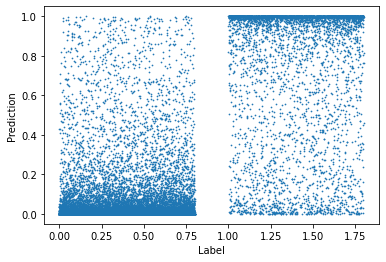

In [200]:
tps = slow_rate_full_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [ ]:
sample_predictions = slow_rate_full_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

## EVALUATION OF ALL METHODS FOR THE *Most common not aves* Dataset

In [44]:
METRICS = [
    lambda : tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
    lambda : tf.keras.metrics.Precision(name='precision'),
    lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

In [45]:
model_dir = os.path.dirname(os.path.realpath("slow_rate_a_model_most_common_not_aves.h5"))
glob.glob(os.path.join(model_dir, '*common_not_aves.h5'))

['/tf/2021J_EMA/CNN_reslinks_most_common_not_aves.h5',
 '/tf/2021J_EMA/CNN_base_most_common_not_aves.h5',
 '/tf/2021J_EMA/CNN_norm_agn_most_common_not_aves.h5',
 '/tf/2021J_EMA/AUTOEN_slowlr_most_common_not_aves.h5',
 '/tf/2021J_EMA/AUTOEN_base_most_common_not_aves.h5',
 '/tf/2021J_EMA/AUTOEN_dropout_most_common_not_aves.h5',
 '/tf/2021J_EMA/CNN_Agnumented_common_not_aves.h5']

In [46]:
common_not_aves_model_dir = []
for path in sorted(glob.glob(os.path.join(model_dir, '*common_not_aves.h5'))):
    common_not_aves_model_dir.append( {'path': path, 'label': os.path.basename(path)} )


In [47]:
def predictions_from_model(path_to_model, return_metrics=True):
    """Load and evaluate a model, return its predictions and optionally metrics"""
    m = tf.keras.models.load_model(path_to_model)
    if return_metrics:
        m.compile(metrics=fresh_metrics())
        metrics = m.evaluate(validation_dataset, return_dict=True)
    preds = m.predict(test_dataset)
    
    if return_metrics:
        return preds, metrics
    else:
        return preds

In [48]:
#Generating accuracy, recalll and precision performance:
for m in common_not_aves_model_dir:
    print(m['label'])
    preds, metrics = predictions_from_model(m['path'], return_metrics=True)
    m['predictions'] = preds
    m['metrics'] = metrics

AUTOEN_base_most_common_not_aves.h5
37/37 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.7841 - precision: 0.7990 - recall: 0.7739
AUTOEN_dropout_most_common_not_aves.h5
37/37 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8173 - precision: 0.8413 - recall: 0.8020
AUTOEN_slowlr_most_common_not_aves.h5
37/37 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7943 - precision: 0.8402 - recall: 0.7641
CNN_Agnumented_common_not_aves.h5
37/37 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8126 - precision: 0.8543 - recall: 0.7901
CNN_base_most_common_not_aves.h5
37/37 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7867 - precision: 0.8324 - recall: 0.7578
CNN_norm_agn_most_common_not_aves.h5
37/37 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8283 - precision: 0.8717 - recall: 0.7969
CNN_resli

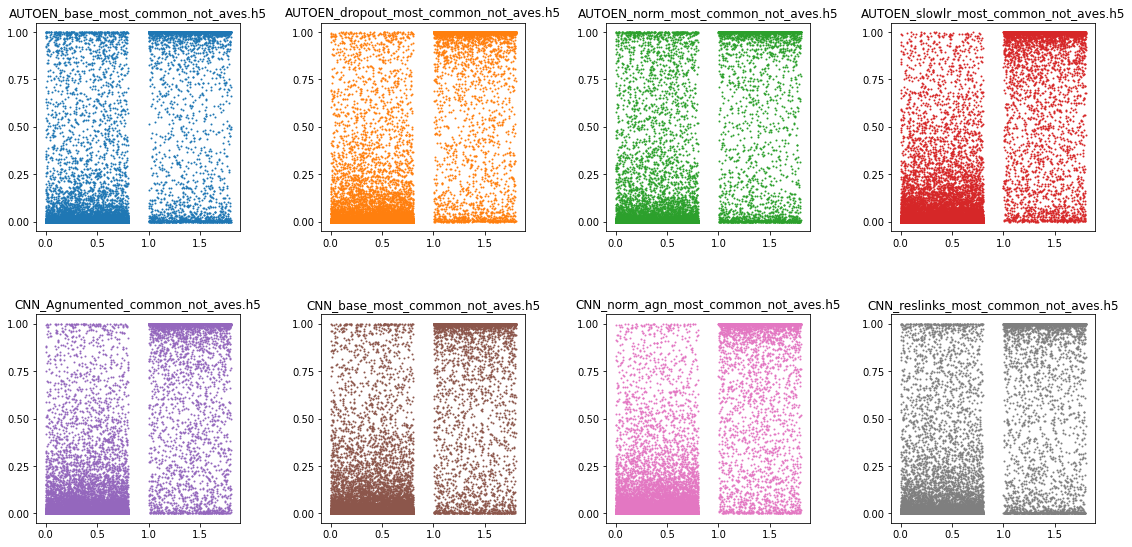

In [63]:
#Comparing scattered plots predicitons:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 10))
for i, m in enumerate(common_not_aves_model_dir):
    plt.subplot(3, 4, i+1)
    plt.scatter(jittered_labels, m['predictions'], s=1, color=colors[i % len(colors)])
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.title(m['label'] )
    plt.tight_layout()
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.08, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)



# 2. DATASET  The filtered_confusing_species* dataset of the distinct bird species:

## Getting up the dataset data:

In [80]:
with open(os.path.join(base_dir, 'filtered_confusing_species_train.json')) as f:
    train_metadata = json.load(f)
train_images = {i['id']: i['file_name'] for i in train_metadata['images']}
species_supercategories = {c['id']: c['supercategory'] for c in train_metadata['categories']}
len(train_metadata['annotations'])

23649

In [81]:
with open(os.path.join(base_dir, 'filtered_confusing_species_validation.json')) as f:
    validation_metadata = json.load(f)
validation_images = {i['id']: i['file_name'] for i in validation_metadata['images']}
len(validation_metadata['annotations'])

3378

In [82]:
with open(os.path.join(base_dir, 'filtered_confusing_species_test.json')) as f:
    test_metadata = json.load(f)
test_images = {i['id']: i['file_name'] for i in test_metadata['images']}
len(test_metadata['annotations'])

6756

In [83]:
train_lenght = len(train_metadata['annotations'])

In [84]:
train_lenght

23649

In [85]:
# Setting up helping methods.

# number of images in each category
species_counts = collections.Counter(a['category_id'] for a in train_metadata['annotations'])

# The label of each class in the dataset
species_classes = {c['id']: i for i, c in enumerate(train_metadata['categories'])}

# The label of each species
species_lookups = {c: l for l, c in species_classes.items()}

# Number of images in each label
class_counts = {c: species_counts[species_lookups[c]] for c in species_lookups}

# Human-sensible names for each class
class_names = {species_classes[c['id']]: c['name'] for c in train_metadata['categories']}

# Number of classes
classes_num = len(species_counts)

# Weights to use of each class, if necessary
all_image_count = len(train_images)
class_weights = {c: all_image_count / (classes_num * class_counts[c]) 
                for c in class_counts}
# number of images in each supercategory
top_counts = collections.Counter(
    species_supercategories[a['category_id']] 
    for a in train_metadata['annotations'])


## Methods to load images and weights:

In [91]:
def lookup_class_weight(label):
    return class_weights[label.numpy()]


def load_image(image_label):
    image_path = image_label['file_name']
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    # grab the label and encode it
    label = image_label['label']
    encoded_label = tf.one_hot(label, classes_num)
    encoded_label = tf.ensure_shape(encoded_label, [classes_num])
    
    # return the image and the one-hot encoded label
    return image, encoded_label

def load_image_weight(image_label):
    image, encoded_label = load_image(image_label)
    label = image_label['label']
    weight = tf.py_function(lookup_class_weight, inp=[label], Tout=tf.float32)
    tf.ensure_shape(weight, [])

    return image, encoded_label, weight

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    dr = Dropout(0.2)(den)
    out = Dense(14, activation='softmax')(dr)
    return out
#(Autoencoder as a Classifier using Fashion-MNIST Dataset Tutorial, 2018)


def scheduler(epoch, lr):
    return lr * 0.95

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Creating the training, validation and test data:

In [92]:
train_filenames = [(os.path.join(base_dir, train_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in train_metadata['annotations']]
train_filenames, train_labels = zip(*train_filenames)
train_filenames = {'file_name': list(train_filenames), 'label': list(train_labels)}

train_dataset_filenames = tf.data.Dataset.from_tensor_slices(train_filenames)
train_dataset_filenames = train_dataset_filenames.shuffle(10**6)

In [93]:
validation_filenames = [(os.path.join(base_dir, validation_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in validation_metadata['annotations']]
validation_filenames, validation_labels = zip(*validation_filenames)
validation_filenames = {'file_name': list(validation_filenames), 'label': list(validation_labels)}

validation_dataset_filenames = tf.data.Dataset.from_tensor_slices(validation_filenames)

In [94]:
test_filenames = [(os.path.join(base_dir, test_images[a['image_id']]),
                    species_classes[a['category_id']]) 
                   for a in test_metadata['annotations']]
test_filenames, test_labels = zip(*test_filenames)
test_filenames = {'file_name': list(test_filenames), 'label': list(test_labels)}

test_dataset_filenames = tf.data.Dataset.from_tensor_slices(test_filenames)

In [96]:
train_dataset = train_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(2000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [97]:
train_dataset_w = train_dataset_filenames.map(load_image_weight, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_w = train_dataset_w.shuffle(2000)
train_dataset_w = train_dataset_w.batch(BATCH_SIZE)
train_dataset_w = train_dataset_w.prefetch(tf.data.AUTOTUNE)

In [98]:
validation_dataset = validation_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [99]:
test_dataset = test_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [100]:
sample_imgs, sample_labels = train_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape

((65, 75, 75, 3), (65, 14))

In [101]:
# Convert a tdfs mnist element into the form we require for training.
def ds_elem_transform(elem):
    return (tf.cast(elem['image'], tf.float32) / 255, # convert to range 0-1
           tf.one_hot(elem['label'], 9) # one-hot encoding, 10 choices
           )

In [102]:
train_dataset

<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14)), types: (tf.float32, tf.float32)>

In [103]:
jittered_test_labels = np.asarray(
    list(test_dataset
        .flat_map(lambda img, lab: tf.data.Dataset.from_tensor_slices(lab))
        .as_numpy_iterator()                
    ))
jittered_test_labels.shape

(6756, 14)

In [104]:
jittered_labels = jittered_test_labels + (np.random.random(jittered_test_labels.shape) * 0.8)
jittered_labels

array([[0.776505  , 0.1081007 , 0.79784725, ..., 0.36827768, 0.28657303,
        0.55111758],
       [0.42967508, 0.17688385, 0.4451763 , ..., 1.44035196, 0.09724384,
        0.00538406],
       [0.02036626, 0.19130275, 0.56073396, ..., 0.56200115, 0.23505194,
        0.60090807],
       ...,
       [0.00903901, 0.31465987, 0.66086354, ..., 0.23305995, 0.08688545,
        0.01257863],
       [0.50915425, 0.26820953, 0.62218236, ..., 0.55792507, 0.0275176 ,
        0.40331945],
       [0.57160236, 0.6807702 , 0.27679861, ..., 0.1096479 , 0.06348383,
        0.51275718]])

## 1th method (filtered_species) : CNN deep learning:




### Creating base CNN model:

In [34]:

base_cnn_model = Sequential([

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='valid', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(14, activation='softmax')
                 
])

In [31]:
base_cnn_model = base_cnn_model

In [32]:
base_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [257]:
base_cnn_model_history = base_cnn_model.fit(
    train_dataset,
    epochs=20,
    verbose=1,
    validation_data=validation_dataset
)



Epoch 1/20
364/364 [==============================] - 10s 24ms/step - loss: 2.1506 - accuracy: 0.3018 - val_loss: 1.7887 - val_accuracy: 0.4038
Epoch 2/20
364/364 [==============================] - 9s 23ms/step - loss: 1.7935 - accuracy: 0.4057 - val_loss: 1.6285 - val_accuracy: 0.4769
Epoch 3/20
364/364 [==============================] - 9s 22ms/step - loss: 1.6019 - accuracy: 0.4671 - val_loss: 1.4321 - val_accuracy: 0.5278
Epoch 4/20
364/364 [==============================] - 9s 22ms/step - loss: 1.4358 - accuracy: 0.5265 - val_loss: 1.4748 - val_accuracy: 0.5018
Epoch 5/20
364/364 [==============================] - 9s 22ms/step - loss: 1.3066 - accuracy: 0.5664 - val_loss: 1.2030 - val_accuracy: 0.5885
Epoch 6/20
364/364 [==============================] - 9s 23ms/step - loss: 1.1947 - accuracy: 0.5996 - val_loss: 1.1317 - val_accuracy: 0.6187
Epoch 7/20
364/364 [==============================] - 9s 23ms/step - loss: 1.0904 - accuracy: 0.6366 - val_loss: 1.1174 - val_accuracy: 0.632

In [263]:
base_cnn_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 1s 13ms/step - loss: 1.1996 - accuracy: 0.6637


{'loss': 1.1996098756790161, 'accuracy': 0.663706362247467}

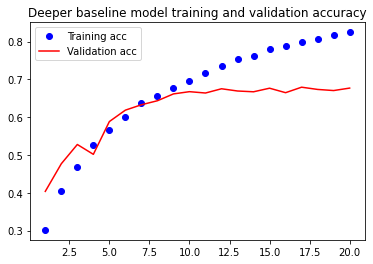

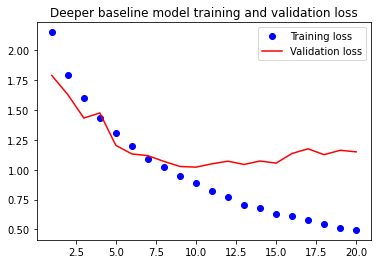

In [264]:
train_acc = base_cnn_model_history.history['accuracy']
val_acc = base_cnn_model_history.history['val_accuracy']
train_loss = base_cnn_model_history.history['loss']
val_loss = base_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Deeper baseline model training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Deeper baseline model training and validation loss')
plt.legend()

In [265]:
base_cnn_model.save('confused_unbalanced_base_cnn_model.h5')
with open('confused_unbalanced_base_cnn_model_history.json', 'w') as f:
    json.dump(base_cnn_model_history.history, f)

In [60]:
confused_base_cnn_model = tf.keras.models.load_model('CNN_unbalanced_filtered_confusing_species.h5')
with open('confused_unbalanced_base_cnn_model_history.json') as f:
    example_history = json.load(f)

In [ ]:
sample_predictions = confused_base_cnn_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()
#output cleared to reduce noteboks size

In [58]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [61]:
test_predictions = confused_base_cnn_model.predict(test_dataset)
predict_labels = np.argmax(test_predictions, axis=1)

In [62]:
from sklearn.metrics import confusion_matrix

In [64]:
# prediction metrix
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  27    0    4    0    3    4   14    6    0    0    0    0    1   15]
 [   0  300   23    0    5   25    3    1    0    0   10  148    4    2]
 [   0   30  560    4   23   65    5    4    0    5   32  125    3   34]
 [   0    0   13  134    3   11    2    6    0    5   17    2   90    9]
 [   0    3    9    3   54   17   18   12    0    0   17    8    6    7]
 [   3   12   70    8   23 1308   11   54    4    7   41   45   13   66]
 [   0    1    7    5   17    9  208    8    0    2    8    4    8   19]
 [   4    1   24    6   14   33    4  405    1    4   42    4    6   39]
 [   0    0    1    0    1    2    0    6   10    0    0    1    0    2]
 [   0    1    8    2    0    7    2   18    0  180   19    3    5    8]
 [   0    7   27    2   19   20    5   27    0   12  346   10   15   37]
 [   0  166   52    3    7   31    1    4    1    0   11  416    4    6]
 [   0    1    3   29    6   29    2    8    0    5   21   11  218    9]
 [   3    1   17    0    8   2

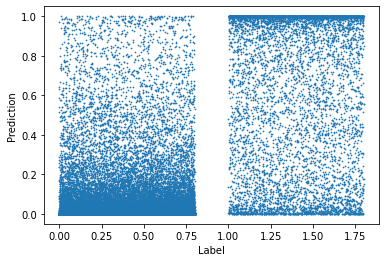

In [83]:
tps = confused_base_cnn_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

### Training with more complex model ( residual link, extra layers ) with weighted dataset due to unbalanced data:

As the dataset is unbalanced and around 3 classes has significantly less images we need to apply higher weighs on those classes
 to improve the training accuracy

In [191]:
def build_res_model(include_skip=True):
    
    rs_model_input = Input(shape=IMAGE_SIZE)
        
    a = Conv2D(filters=32, kernel_size=(1,1), padding='same',  activation='relu')(rs_model_input)
    b = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(a)
    c = Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(b)
    
    if include_skip:
        ac = Add()([a, c])
    else:
        ac = c

    d = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(ac)
    e = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(d)
    f = Conv2D(filters=64, kernel_size=(1,1), padding='valid', activation='relu')(e)

    if include_skip:
        df = Add()([d, f])
    else:
        df = f
        
    g = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(df)
    h = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(g)
    i = Conv2D(filters=128, kernel_size=(1,1),  padding='valid', activation='relu')(h)

    if include_skip:
        gi = Add()([g, i])
    else:
        gi = i
    
    j = Conv2D(filters=258, kernel_size=(1,1), strides=(2,2), padding='same', activation='relu')(gi)
    k = Conv2D(filters=258, kernel_size=(3,3), padding='same', activation='relu')(j)
    l = Conv2D(filters=258, kernel_size=(1,1),  padding='valid', activation='relu')(k)
 
    
    if include_skip:
        jl = Add()([j, l])
    else:
        jl = l
    
    
    x = Flatten()(jl)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) 
    x = Dense(14, activation='softmax')(x)

    return tf.keras.Model(inputs=rs_model_input, outputs=x, name='build_res_model')

In [192]:
res_no_res_model = build_res_model(include_skip=True)

In [193]:
res_no_res_model.compile(
    optimizer=tf.keras.optimizers.Adam(), # Lower initial learning rate
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [194]:
validation_dataset, train_dataset_w

(<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14), <unknown>), types: (tf.float32, tf.float32, tf.float32)>)

In [195]:
validation_dataset, train_dataset_w

(<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14), <unknown>), types: (tf.float32, tf.float32, tf.float32)>)

In [196]:
res_no_res_model_history = res_no_res_model.fit(
    train_dataset_w,
    epochs=30,
    verbose=1,
    validation_data=validation_dataset,
)

Epoch 1/30
364/364 [==============================] - 24s 63ms/step - loss: 2.4271 - accuracy: 0.1666 - val_loss: 2.2835 - val_accuracy: 0.2066
Epoch 2/30
364/364 [==============================] - 24s 64ms/step - loss: 2.2001 - accuracy: 0.2121 - val_loss: 2.0567 - val_accuracy: 0.3085
Epoch 3/30
364/364 [==============================] - 23s 62ms/step - loss: 2.0511 - accuracy: 0.2611 - val_loss: 1.9575 - val_accuracy: 0.3197
Epoch 4/30
364/364 [==============================] - 24s 63ms/step - loss: 1.9572 - accuracy: 0.2909 - val_loss: 1.8517 - val_accuracy: 0.3674
Epoch 5/30
364/364 [==============================] - 23s 63ms/step - loss: 1.8103 - accuracy: 0.3237 - val_loss: 1.7384 - val_accuracy: 0.4097
Epoch 6/30
364/364 [==============================] - 23s 63ms/step - loss: 1.7251 - accuracy: 0.3507 - val_loss: 1.6689 - val_accuracy: 0.4130
Epoch 7/30
364/364 [==============================] - 23s 63ms/step - loss: 1.6629 - accuracy: 0.3660 - val_loss: 1.5835 - val_accuracy:

In [197]:
res_no_res_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 2s 16ms/step - loss: 1.5573 - accuracy: 0.5853


{'loss': 1.5573487281799316, 'accuracy': 0.5852575302124023}

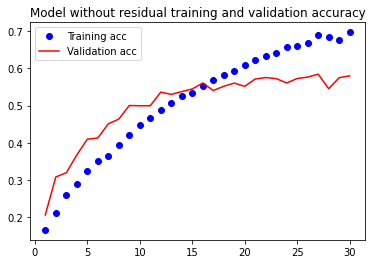

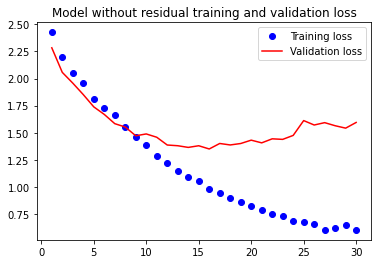

In [198]:
train_acc = res_no_res_model_history.history['accuracy']
val_acc = res_no_res_model_history.history['val_accuracy']
train_loss = res_no_res_model_history.history['loss']
val_loss = res_no_res_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Model without residual training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Model without residual training and validation loss')
plt.legend()

In [ ]:
res_no_res_model.save('confused_balanced_res_no_res_model.h5')
with open('confused_res_no_res_model_history.json', 'w') as f:
    json.dump(res_no_res_model_history.history, f)

In [88]:
res_no_res_model = tf.keras.models.load_model('CNN_weighted_reslinks_filtered_confusing_species.h5')
with open('confused_res_no_res_model_history.json') as f:
    res_no_res_model_history = json.load(f)

In [ ]:
sample_predictions = res_no_res_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

#Output cleared to reduce size of the notebook

In [79]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [80]:
test_predictions = res_no_res_model.predict(test_dataset)
predict_labels = np.argmax(test_predictions, axis=1)

In [81]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  24    0    2    0    3    3   29    2    1    0    4    0    0    6]
 [   0  322   42    1    2   26    1    0    0    2   13  108    2    2]
 [   2   54  508    5   16  109   13   11    4   13   39   69    7   40]
 [   0    3    9  150    5   22    3    5    0    6   21    4   55    9]
 [   1    6   26    2   54   10   10    8    0    0   17    9    6    5]
 [   2   23  130   13   16 1152   26   40   12   15   98   30   28   80]
 [  13    4   21    2   12   11  186    4    2    6   11    3    3   18]
 [   1    1   37    2    7   46   11  323    2   22   83    4    5   43]
 [   0    0    4    0    2    1    1    0   10    0    2    0    0    3]
 [   0    2   20    1    1   25    2    6    0  143   30    6    2   15]
 [   3   12   55    6    9   34    8   21    3   32  302    3    5   34]
 [   0  210   95    5    6   39    4    3    1    6    8  312    6    7]
 [   0    2    9   46    2   30    9    5    2    3   26    4  194   10]
 [   6    1   32    2    4   4

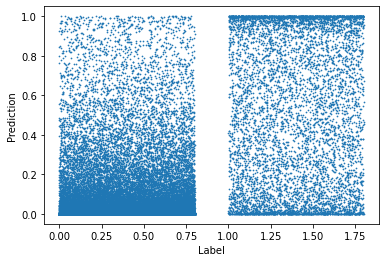

In [82]:
tps = res_no_res_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

### Using augmentation on the CNN model :

In [79]:
aug_train_data


<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14)), types: (tf.float32, tf.float32)>

In [201]:
# Defining of how to agnument data:
# I have used RandomRotation, RandomZoom and RandomFlip.
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2),
    layers.RandomFlip(mode='horizontal')
])

#Agnument the train data:
    
aug_train_data = train_dataset_w.map(lambda x, y, z: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [202]:
agnumented_cnn_model = Sequential([

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='valid', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(14, activation='softmax')
                 
])

In [203]:
agnumented_cnn_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [204]:
agnumented_cnn_model_history = agnumented_cnn_model.fit(aug_train_data,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    )

Epoch 1/100
364/364 [==============================] - 22s 56ms/step - loss: 2.2632 - accuracy: 0.2651 - val_loss: 2.0421 - val_accuracy: 0.2969
Epoch 2/100
364/364 [==============================] - 21s 56ms/step - loss: 2.0011 - accuracy: 0.3283 - val_loss: 1.7596 - val_accuracy: 0.3854
Epoch 3/100
364/364 [==============================] - 21s 56ms/step - loss: 1.8385 - accuracy: 0.3784 - val_loss: 1.6082 - val_accuracy: 0.4479
Epoch 4/100
364/364 [==============================] - 21s 56ms/step - loss: 1.7241 - accuracy: 0.4149 - val_loss: 1.7139 - val_accuracy: 0.4269
Epoch 5/100
364/364 [==============================] - 21s 56ms/step - loss: 1.6272 - accuracy: 0.4557 - val_loss: 1.4588 - val_accuracy: 0.4997
Epoch 6/100
364/364 [==============================] - 21s 56ms/step - loss: 1.5384 - accuracy: 0.4856 - val_loss: 1.3264 - val_accuracy: 0.5477
Epoch 7/100
364/364 [==============================] - 21s 56ms/step - loss: 1.4713 - accuracy: 0.5097 - val_loss: 1.3344 - val_ac

<Figure size 432x288 with 0 Axes>

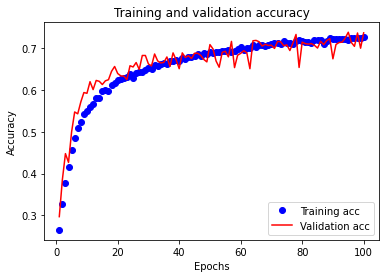

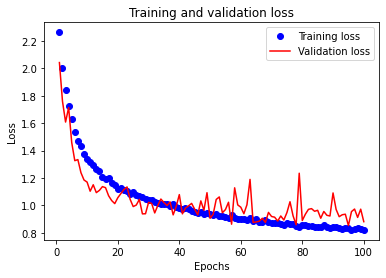

<Figure size 432x288 with 0 Axes>

In [205]:
train_acc = agnumented_cnn_model_history.history['accuracy']
val_acc = agnumented_cnn_model_history.history['val_accuracy']
train_loss = agnumented_cnn_model_history.history['loss']
val_loss = agnumented_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()

In [85]:
CNN_weighted_agn_filtered_confusing_species.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 1s 13ms/step - loss: 0.8898 - accuracy: 0.7207


{'loss': 0.8897556662559509, 'accuracy': 0.7206926941871643}

In [207]:
agnumented_cnn_model.save('CNN_weighted_agn_filtered_confusing_species.h5')
with open('balanced_agnumented_cnn_model.json', 'w') as f:
    json.dump(agnumented_cnn_model_history.history, f)

In [86]:
CNN_weighted_agn_filtered_confusing_species = tf.keras.models.load_model('CNN_weighted_agn_filtered_confusing_species.h5')
with open('agnumented_cnn_model_history.json') as f:
    balanced_agnumented_cnn_model = json.load(f)

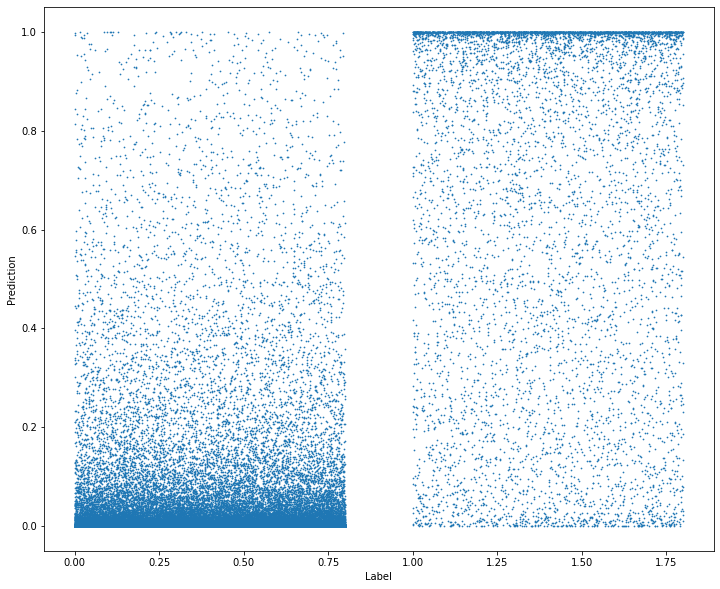

In [87]:
tps = CNN_weighted_agn_filtered_confusing_species.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [ ]:
sample_predictions = CNN_weighted_agn_filtered_confusing_species(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()
#output cleared to reduce size of the notebook

In [100]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [101]:
test_predictions = CNN_weighted_agn_filtered_confusing_species.predict(test_dataset)
predict_labels = np.argmax(test_predictions, axis=1)

In [102]:
predicted_classes = np.argmax(np.round(test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                    precision    recall  f1-score   support

Picoides nuttallii       0.05      0.91      0.10        74
     Egretta thula       0.71      0.45      0.55       521
    Ardea herodias       0.72      0.69      0.71       890
   Spinus psaltria       0.70      0.64      0.67       292
Sitta carolinensis       0.92      0.39      0.55       154
Anas platyrhynchos       0.89      0.80      0.84      1665
Picoides pubescens       0.92      0.63      0.75       296
Turdus migratorius       0.94      0.63      0.75       587
    Megascops asio       1.00      0.22      0.36        23
  Falco sparverius       0.77      0.67      0.72       253
  Zenaida macroura       0.78      0.66      0.71       527
        Ardea alba       0.72      0.59      0.65       702
    Spinus tristis       0.85      0.49      0.62       342
  Sturnus vulgaris       0.73      0.74      0.74       430

          accuracy                           0.66      6756
         macro avg       0.76      0.6

In [103]:
predict_labels = np.argmax(test_predictions, axis=1)

In [104]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  54    0    1    0    0    4    1    6    0    0    1    0    0    7]
 [   0  263   56    0    0   27    5    0    0    2    6  157    1    4]
 [   1   20  678    1    0   65    1    5    1    9   32   42    3   32]
 [   1    0    8  203    1   18    1    5    0    3   14    2   28    8]
 [   1    1   30    1   70    9   11    4    1    1   22    0    0    3]
 [   4    5  106    6    1 1421    4   12    1    2   29   15   11   48]
 [  39    1   13    3    5   12  202    3    1    4    4    1    1    7]
 [   6    1   29    1    2   44    3  408    0   22   30    1    5   35]
 [   0    0    2    0    0   10    0    0    8    0    1    0    0    2]
 [   1    0   18    1    0   13    2    7    0  182   10    1    1   17]
 [   0    0   41    1    2   23    2    7    0   21  397    5    7   21]
 [   0   94   94    1    0   25    1    2    1    2   14  459    2    7]
 [   1    1    6   91    2   15    6    6    0    5   20    4  183    2]
 [   3    1   19    1    0   3

### Adding normalisation to the augnumented CNN model :

In [210]:
# Adding normalisation layer to the agnumented model:
norm_layer = layers.Normalization(input_shape=IMAGE_SIZE)

norm_agnumented_cnn_model = Sequential([
    
    norm_layer,

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='same', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(14, activation='softmax')
                 
])

In [211]:
norm_agnumented_cnn_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [212]:
norm_agnumented_cnn_model_history = norm_agnumented_cnn_model.fit(aug_train_data,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    )

Epoch 1/100
364/364 [==============================] - 22s 56ms/step - loss: 2.2715 - accuracy: 0.2645 - val_loss: 2.0657 - val_accuracy: 0.2957
Epoch 2/100
364/364 [==============================] - 21s 56ms/step - loss: 2.0130 - accuracy: 0.3282 - val_loss: 1.7949 - val_accuracy: 0.3831
Epoch 3/100
364/364 [==============================] - 21s 56ms/step - loss: 1.8694 - accuracy: 0.3726 - val_loss: 1.6479 - val_accuracy: 0.4242
Epoch 4/100
364/364 [==============================] - 21s 56ms/step - loss: 1.7463 - accuracy: 0.4179 - val_loss: 1.5436 - val_accuracy: 0.4665
Epoch 5/100
364/364 [==============================] - 21s 56ms/step - loss: 1.6674 - accuracy: 0.4491 - val_loss: 1.5099 - val_accuracy: 0.4728
Epoch 6/100
364/364 [==============================] - 21s 56ms/step - loss: 1.5988 - accuracy: 0.4666 - val_loss: 1.4407 - val_accuracy: 0.5118
Epoch 7/100
364/364 [==============================] - 21s 56ms/step - loss: 1.5373 - accuracy: 0.4859 - val_loss: 1.3675 - val_ac

<Figure size 432x288 with 0 Axes>

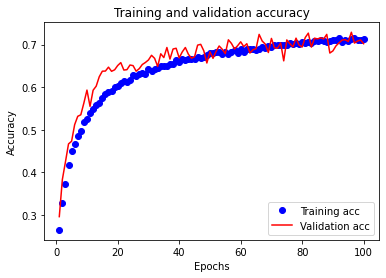

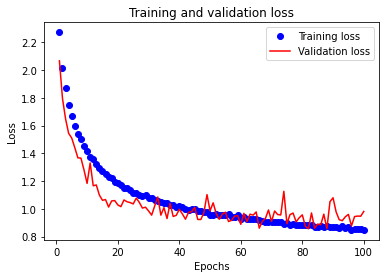

<Figure size 432x288 with 0 Axes>

In [213]:
train_acc = norm_agnumented_cnn_model_history.history['accuracy']
val_acc = norm_agnumented_cnn_model_history.history['val_accuracy']
train_loss = norm_agnumented_cnn_model_history.history['loss']
val_loss = norm_agnumented_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()

In [214]:
norm_agnumented_cnn_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 1s 14ms/step - loss: 0.9735 - accuracy: 0.7069


{'loss': 0.973475456237793, 'accuracy': 0.7069271802902222}

In [218]:
norm_agnumented_cnn_model.save('balanced_norm_agnumented_cnn_model.h5')
with open('balanced_norm_agnumented_cnn_model_history.json', 'w') as f:
    json.dump(norm_agnumented_cnn_model_history.history, f)

In [71]:
norm_agnumented_cnn_model = tf.keras.models.load_model('CNN_w_agn_norm_filtered_confusing_species.h5')
with open('balanced_norm_agnumented_cnn_model_history.json') as f:
    agnumented_cnn_model_history = json.load(f)

In [ ]:
sample_predictions = norm_agnumented_cnn_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

# output cleared to reduce notebook size

In [72]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [74]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  54    0    1    0    0    5    7    2    0    0    0    0    0    5]
 [   0  272   50    0    4   38    2    3    0    4    7  136    2    3]
 [   9   15  630    1    1  104    9    4    0    8   20   32    1   56]
 [   6    0    5  160    0   29   12    4    0    1    8    1   58    8]
 [   1    0   23    0   68    8   24    4    1    2   11    1    4    7]
 [  12    1   68    1    2 1466   15   10    0    4   10   11    7   58]
 [  17    2   10    0    4    8  236    1    1    3    3    1    2    8]
 [  11    0   26    2    4   54    4  390    2   13   18    1    4   58]
 [   2    0    0    0    0    6    2    0    7    0    0    0    0    6]
 [   3    0   14    1    0   21    2    5    0  158   17    1    0   31]
 [   2    1   34    1    3   34    6   15    0   13  354    2   11   51]
 [   0  122   92    2    1   42    5    7    0    1   13  406    5    6]
 [   2    0    6   35    0   20   17    9    0    5   12    0  229    7]
 [   7    0   12    0    1   3

## Reducing the amount of samples for class 6  :

In [47]:
train_dataset = train_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
reduced_train_dataset = train_dataset_filenames.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [48]:
#showing the emount of samples in each class:
train_dataset.reduce(tf.zeros((14,)),
                             lambda o, il: tf.math.add(o, il[1])).numpy()

array([ 216., 1772., 2958., 1036.,  607., 5923., 1095., 1993.,  116.,
        934., 1742., 2560., 1187., 1510.], dtype=float32)

In [49]:
# creating datasets with and without class 5
only_fives = train_dataset.filter(lambda i, l: tf.math.argmax(l) == 5)
not_fives = train_dataset.filter(lambda i, l: tf.math.argmax(l) != 5)

In [50]:
#reducing class five samples to around 2000:
only_fives_subset = only_fives.shuffle(2000).shard(3, 0)
only_fives_subset.reduce(tf.zeros((14,)),
                             lambda o, il: tf.math.add(o, il[1])).numpy()

array([   0.,    0.,    0.,    0.,    0., 1975.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.], dtype=float32)

In [51]:
# Merging the datasets together to create new reduced dataset:
reduced_train_dataset = not_fives.concatenate(only_fives_subset)

In [52]:
reduced_train_dataset = reduced_train_dataset.shuffle(2000)
reduced_train_dataset = reduced_train_dataset.batch(BATCH_SIZE)
reduced_train_dataset = reduced_train_dataset.prefetch(tf.data.AUTOTUNE)

### Training the model on dataset with reduced samples in class 6 :

In [79]:
aug_train_data


<PrefetchDataset shapes: ((None, 75, 75, 3), (None, 14)), types: (tf.float32, tf.float32)>

In [53]:
# Defining of how to agnument data:
# I have used RandomRotation, RandomZoom and RandomFlip.
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2),
    layers.RandomFlip(mode='horizontal')
])

#Agnument the train data:
    
aug_train_data = reduced_train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
reduced_cnn_model = Sequential([

    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=IMAGE_SIZE, activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  

    Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),     
                 
    Conv2D(filters=258, kernel_size=(3,3), padding='valid', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(14, activation='softmax')
                 
])

In [55]:
reduced_cnn_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [56]:
reduced_cnn_model_history = reduced_cnn_model.fit(aug_train_data,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    )

Epoch 1/100
304/304 [==============================] - 27s 73ms/step - loss: 2.2423 - accuracy: 0.2507 - val_loss: 2.4421 - val_accuracy: 0.2504
Epoch 2/100
304/304 [==============================] - 22s 69ms/step - loss: 2.0698 - accuracy: 0.3081 - val_loss: 2.1817 - val_accuracy: 0.2724
Epoch 3/100
304/304 [==============================] - 22s 71ms/step - loss: 1.9740 - accuracy: 0.3381 - val_loss: 2.1011 - val_accuracy: 0.2789
Epoch 4/100
304/304 [==============================] - 22s 69ms/step - loss: 1.8837 - accuracy: 0.3748 - val_loss: 2.0344 - val_accuracy: 0.3209
Epoch 5/100
304/304 [==============================] - 22s 69ms/step - loss: 1.7630 - accuracy: 0.4095 - val_loss: 1.9490 - val_accuracy: 0.3499
Epoch 6/100
304/304 [==============================] - 22s 69ms/step - loss: 1.6829 - accuracy: 0.4370 - val_loss: 1.9943 - val_accuracy: 0.3665
Epoch 7/100
304/304 [==============================] - 22s 70ms/step - loss: 1.6469 - accuracy: 0.4504 - val_loss: 1.8984 - val_ac

<Figure size 432x288 with 0 Axes>

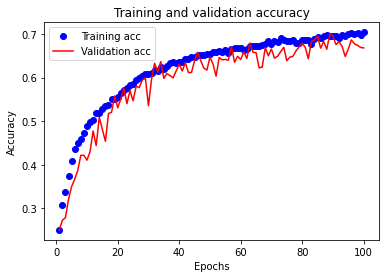

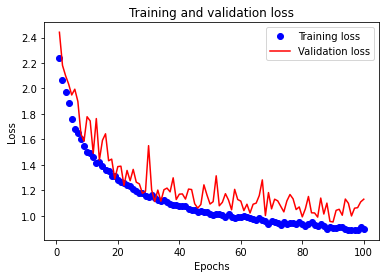

<Figure size 432x288 with 0 Axes>

In [57]:
train_acc = reduced_cnn_model_history.history['accuracy']
val_acc = reduced_cnn_model_history.history['val_accuracy']
train_loss = reduced_cnn_model_history.history['loss']
val_loss = reduced_cnn_model_history.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()

In [206]:
reduced_cnn_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 1s 13ms/step - loss: 0.8898 - accuracy: 0.7207


{'loss': 0.8897556662559509, 'accuracy': 0.7206926941871643}

In [58]:
reduced_cnn_model.save('CNN_reduced_agn_filtered_confusing_species.h5')
with open('reduced_cnn_model_history.json', 'w') as f:
    json.dump(reduced_cnn_model_history.history, f)

In [86]:
reduced_cnn_model = tf.keras.models.load_model('CNN_reduced_agn_filtered_confusing_species.h5')
with open('reduced_cnn_model_history.json') as f:
    balanced_agnumented_cnn_model = json.load(f)

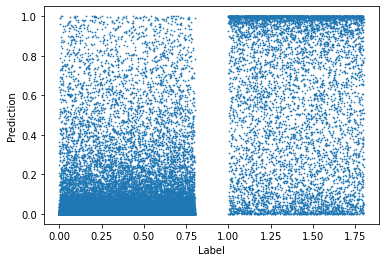

In [59]:
tps = reduced_cnn_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [ ]:
sample_predictions = reduced_cnn_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

#output cleared to reduce size of the noteboook

In [62]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [63]:
test_predictions = reduced_cnn_model.predict(test_dataset)
predict_labels = np.argmax(test_predictions, axis=1)

In [64]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  56    0    0    0    0   11    1    0    1    0    0    0    0    5]
 [   0  210   52    0    4   75    3    0    0    0    4  172    1    0]
 [   1   10  595    0    2  209    3    2    2    5   13   28    0   20]
 [   0    0   16  149    0   69    6    1    0    7    7    0   22   15]
 [   1    0   42    0   46   39    5    2    0    2   13    1    1    2]
 [   7    2   47    1    3 1548    3    1    0    3    6    8    1   35]
 [  51    0   16    2    1   42  169    1    0    4    3    0    2    5]
 [   2    0   18    1    0  184    3  309    5   14   13    1    0   37]
 [   1    0    1    0    0   11    0    0    6    0    2    0    0    2]
 [   0    0    9    0    0   58    0    3    0  148    6    0    0   29]
 [   0    0   52    0    0  100    0    7    1   15  324    2    2   24]
 [   0   66   94    1    1   99    1    1    0    1    6  429    0    3]
 [   2    0   11   77    1   93    9    4    0    6   16    0  115    8]
 [   8    0    9    0    0  10

## 2th method (filtered_species) : Autoencoders image classification





### Training the autoencoder base model:

#### Training the autoencoder encoder model:

In [269]:
def encoder(input_img):
 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

def decoder(conv4):    
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    x = UpSampling2D((2,2))(x) 

    
  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = UpSampling2D((2,2))(x) 
   

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x) 

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x) 
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(14, activation='softmax')(dp4)
    
    

    return decoded


In [270]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer ='adam')

In [271]:
autoencoder_train = autoencoder.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    epochs=20,
)

Epoch 1/20
364/364 [==============================] - 21s 51ms/step - loss: 0.0651 - val_loss: 0.0658
Epoch 2/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0637 - val_loss: 0.0720
Epoch 3/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0628 - val_loss: 0.0648
Epoch 4/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0620 - val_loss: 0.0781
Epoch 5/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0615 - val_loss: 0.0659
Epoch 6/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0605 - val_loss: 0.0676
Epoch 7/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0622 - val_loss: 0.0705
Epoch 8/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0599 - val_loss: 0.0613
Epoch 9/20
364/364 [==============================] - 19s 49ms/step - loss: 0.0592 - val_loss: 0.0676
Epoch 10/20
364/364 [==============================] - 19s 49ms/step - loss: 0.058

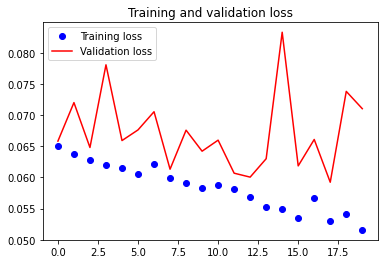

In [273]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [275]:
def encoder(input_img):
  
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

In [277]:
# adding fully connected layeres to the encoder:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


In [278]:
#Adding weightsfrom autoencoder to encoder:
for l1,l2 in zip(full_model.layers[:14],autoencoder.layers[0:14]):
    l1.set_weights(l2.get_weights())

In [279]:
#turning alredy trained weights off and training only the new connected layers:
for layer in full_model.layers[0:14]:
    layer.trainable = False

In [280]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

In [281]:
classify_train = full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=10,verbose=1,validation_data=(validation_dataset))

Epoch 1/10
364/364 [==============================] - 7s 18ms/step - loss: 1.7925 - accuracy: 0.3975 - val_loss: 1.6436 - val_accuracy: 0.4287
Epoch 2/10
364/364 [==============================] - 7s 17ms/step - loss: 1.6756 - accuracy: 0.4322 - val_loss: 1.6186 - val_accuracy: 0.4375
Epoch 3/10
364/364 [==============================] - 7s 18ms/step - loss: 1.6498 - accuracy: 0.4378 - val_loss: 1.6125 - val_accuracy: 0.4417
Epoch 4/10
364/364 [==============================] - 7s 17ms/step - loss: 1.6328 - accuracy: 0.4455 - val_loss: 1.5942 - val_accuracy: 0.4517
Epoch 5/10
364/364 [==============================] - 7s 17ms/step - loss: 1.6177 - accuracy: 0.4513 - val_loss: 1.5835 - val_accuracy: 0.4589
Epoch 6/10
364/364 [==============================] - 7s 17ms/step - loss: 1.6078 - accuracy: 0.4571 - val_loss: 1.5813 - val_accuracy: 0.4589
Epoch 7/10
364/364 [==============================] - 7s 17ms/step - loss: 1.5952 - accuracy: 0.4599 - val_loss: 1.5757 - val_accuracy: 0.4665

In [282]:
#reTraining the whole model:
for layer in full_model.layers[0:14]:
    layer.trainable = True

In [283]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer= 'Adam',metrics=['accuracy'])

In [284]:
classify_train = full_model.fit(train_dataset, batch_size=64,epochs=20,verbose=1,validation_data=(validation_dataset))

Epoch 1/20
364/364 [==============================] - 9s 23ms/step - loss: 1.4616 - accuracy: 0.5064 - val_loss: 2.1060 - val_accuracy: 0.3647
Epoch 2/20
364/364 [==============================] - 9s 23ms/step - loss: 1.3291 - accuracy: 0.5512 - val_loss: 1.5501 - val_accuracy: 0.4935
Epoch 3/20
364/364 [==============================] - 9s 23ms/step - loss: 1.2297 - accuracy: 0.5829 - val_loss: 1.3362 - val_accuracy: 0.5491
Epoch 4/20
364/364 [==============================] - 9s 23ms/step - loss: 1.1337 - accuracy: 0.6202 - val_loss: 1.2775 - val_accuracy: 0.5796
Epoch 5/20
364/364 [==============================] - 9s 23ms/step - loss: 1.0635 - accuracy: 0.6413 - val_loss: 1.1316 - val_accuracy: 0.6175
Epoch 6/20
364/364 [==============================] - 9s 23ms/step - loss: 1.1769 - accuracy: 0.6070 - val_loss: 2.1806 - val_accuracy: 0.3973
Epoch 7/20
364/364 [==============================] - 9s 23ms/step - loss: 1.0471 - accuracy: 0.6485 - val_loss: 1.6458 - val_accuracy: 0.5009

In [290]:
full_model.save_weights('weighted_classification_complete.h5')

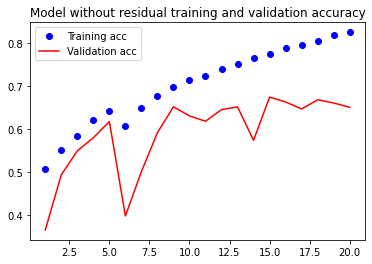

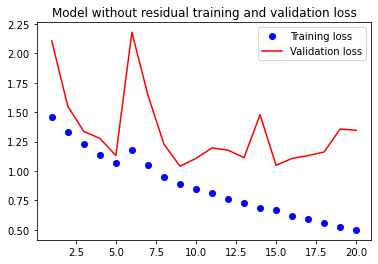

In [291]:
train_acc = classify_train.history['accuracy']
val_acc = classify_train.history['val_accuracy']
train_loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Model without residual training and validation accuracy')
plt.legend() # show legend 
plt.show()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Model without residual training and validation loss')
plt.legend()

In [292]:
full_model.save('weighted_base_a_model.h5')

with open('weighted_base_a_model_history.json', 'w') as f:
    json.dump(classify_train.history, f)

In [84]:
base_A_model = tf.keras.models.load_model('AUTOEN_weighted_base_filtered_confusing_species.h5')
with open('base_a_model_history.json') as f:
    example_history = json.load(f)

#### Evaluating the base models performance:

In [85]:
#test_eval = full_model.evaluate(train_dataset, verbose=0)
base_A_model.evaluate(test_dataset, return_dict=True)


104/104 [==============================] - 1s 13ms/step - loss: 1.3757 - accuracy: 0.6454


{'loss': 1.3756524324417114, 'accuracy': 0.645352303981781}

In [102]:
base_test_predictions = base_A_model.predict(test_dataset)
base_test_predictions.shape

(6756, 14)

In [103]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

(6756,)

In [104]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [105]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()

Text(0, 0.5, 'Prediction')

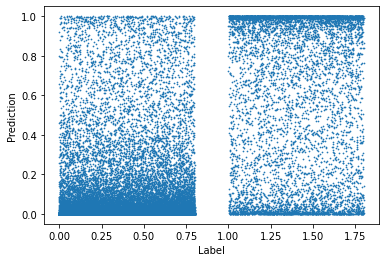

In [106]:
tps = base_A_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction')

In [120]:
#classification report:
predicted_classes = np.argmax(np.round(base_test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                    precision    recall  f1-score   support

Picoides nuttallii       0.04      0.47      0.08        74
     Egretta thula       0.59      0.63      0.61       521
    Ardea herodias       0.75      0.62      0.68       890
   Spinus psaltria       0.84      0.30      0.44       292
Sitta carolinensis       0.34      0.50      0.41       154
Anas platyrhynchos       0.87      0.76      0.81      1665
Picoides pubescens       0.73      0.73      0.73       296
Turdus migratorius       0.96      0.38      0.55       587
    Megascops asio       0.46      0.26      0.33        23
  Falco sparverius       0.95      0.34      0.50       253
  Zenaida macroura       0.43      0.83      0.56       527
        Ardea alba       0.72      0.49      0.58       702
    Spinus tristis       0.67      0.60      0.63       342
  Sturnus vulgaris       0.71      0.65      0.68       430

          accuracy                           0.61      6756
         macro avg       0.65      0.5

In [ ]:
sample_predictions = full_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

### Adding dropout and normalisation layers:

#### Training the encoder model:

In [42]:
def dropout_encoder(input_img):
    
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

def dropout_decoder(conv4): 
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 

    
  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
   

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(14, activation='softmax')(dp4)
    
    

    return decoded

In [43]:
weighted_utoencoder = Model(input_img, dropout_decoder(dropout_encoder(input_img)))
weighted_utoencoder.compile(loss='mean_squared_error', optimizer ='Adam')

In [44]:
#Training the normalisation model:
weighted_dropout_autoencoder_train = weighted_utoencoder.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    epochs=20,
)

Epoch 1/40
364/364 [==============================] - 29s 65ms/step - loss: 0.1327 - val_loss: 0.1357
Epoch 2/40
364/364 [==============================] - 23s 61ms/step - loss: 0.1328 - val_loss: 0.1367
Epoch 3/40
364/364 [==============================] - 23s 61ms/step - loss: 0.1318 - val_loss: 0.1382
Epoch 4/40
364/364 [==============================] - 23s 61ms/step - loss: 0.1327 - val_loss: 0.1390
Epoch 5/40
364/364 [==============================] - 23s 60ms/step - loss: 0.1352 - val_loss: 0.1308
Epoch 6/40
364/364 [==============================] - 23s 60ms/step - loss: 0.1348 - val_loss: 0.1302
Epoch 7/40
364/364 [==============================] - 23s 61ms/step - loss: 0.1347 - val_loss: 0.1333
Epoch 8/40
364/364 [==============================] - 23s 61ms/step - loss: 0.1344 - val_loss: 0.1270
Epoch 9/40
364/364 [==============================] - 23s 60ms/step - loss: 0.1311 - val_loss: 0.1299
Epoch 10/40
364/364 [==============================] - 23s 61ms/step - loss: 0.131

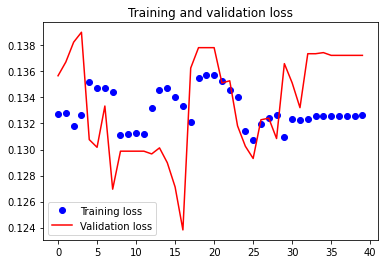

In [45]:
loss = weighted_dropout_autoencoder_train.history['loss']
val_loss = weighted_dropout_autoencoder_train.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
def dropout_encoder(input_img):
   
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4


In [48]:

dropout_encode = dropout_encoder(input_img)
dropout_full_model = Model(input_img,fc(dropout_encode))

In [51]:
for l1,l2 in zip(dropout_full_model.layers[:24],weighted_utoencoder.layers[0:24]):
    l1.set_weights(l2.get_weights())

In [52]:
# as the original encoder part is originaly trained, we disable those layers for the training:
for layer in dropout_full_model.layers[0:24]:
    layer.trainable = False


In [54]:
# compaling model:
dropout_full_model.compile(loss='categorical_crossentropy', optimizer ='adam',metrics=['accuracy'])

In [55]:
# Training model :
dropout_classify_train = dropout_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))


Epoch 1/30
364/364 [==============================] - 8s 18ms/step - loss: 2.3360 - accuracy: 0.2297 - val_loss: 2.2300 - val_accuracy: 0.2410
Epoch 2/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2630 - accuracy: 0.2460 - val_loss: 2.2227 - val_accuracy: 0.2374
Epoch 3/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2451 - accuracy: 0.2485 - val_loss: 2.2049 - val_accuracy: 0.2537
Epoch 4/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2329 - accuracy: 0.2543 - val_loss: 2.2060 - val_accuracy: 0.2481
Epoch 5/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2270 - accuracy: 0.2555 - val_loss: 2.2021 - val_accuracy: 0.2454
Epoch 6/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2199 - accuracy: 0.2561 - val_loss: 2.1959 - val_accuracy: 0.2472
Epoch 7/30
364/364 [==============================] - 7s 18ms/step - loss: 2.2157 - accuracy: 0.2595 - val_loss: 2.1918 - val_accuracy: 0.2442

In [56]:
# Re training the model now again with all of the layers enabled for training:
for layer in dropout_full_model.layers[0:24]:
    layer.trainable = True


In [57]:
dropout_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
# Training the model:
dropout_classify_train = dropout_full_model.fit(train_dataset, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))

Epoch 1/30
364/364 [==============================] - 12s 30ms/step - loss: 2.0137 - accuracy: 0.3169 - val_loss: 1.9101 - val_accuracy: 0.3416
Epoch 2/30
364/364 [==============================] - 11s 30ms/step - loss: 1.7312 - accuracy: 0.4163 - val_loss: 1.6965 - val_accuracy: 0.4355
Epoch 3/30
364/364 [==============================] - 11s 30ms/step - loss: 1.4954 - accuracy: 0.5023 - val_loss: 1.4389 - val_accuracy: 0.5160
Epoch 4/30
364/364 [==============================] - 11s 30ms/step - loss: 1.3251 - accuracy: 0.5582 - val_loss: 1.2986 - val_accuracy: 0.5731
Epoch 5/30
364/364 [==============================] - 11s 30ms/step - loss: 1.2030 - accuracy: 0.5992 - val_loss: 1.2662 - val_accuracy: 0.5891
Epoch 6/30
364/364 [==============================] - 11s 30ms/step - loss: 1.0963 - accuracy: 0.6336 - val_loss: 1.1201 - val_accuracy: 0.6240
Epoch 7/30
364/364 [==============================] - 11s 30ms/step - loss: 1.0333 - accuracy: 0.6510 - val_loss: 1.1422 - val_accuracy:

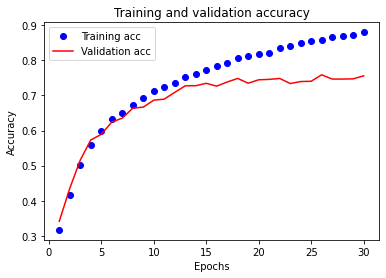

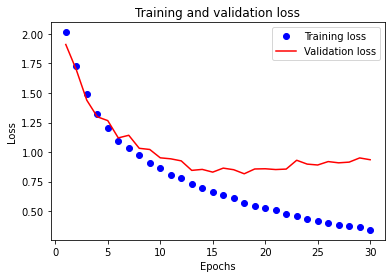

In [61]:
train_acc = dropout_classify_train.history['accuracy']
val_acc = dropout_classify_train.history['val_accuracy']
train_loss = dropout_classify_train.history['loss']
val_loss = dropout_classify_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [62]:
dropout_full_model.save('AUTOEN_w_drop_filtered_confusing_species.h5')
with open('weighted_dropout_a_model.json', 'w') as f:
    json.dump(dropout_classify_train.history, f)

In [106]:
dropout_A_model = tf.keras.models.load_model('AUTOEN_w_drop_filtered_confusing_species.h5')
with open('weighted_dropout_a_model.json') as f:
    example_history = json.load(f)

#### Evaluating the model with added dropout and normalisation layers:

In [107]:
dropout_A_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 2s 13ms/step - loss: 1.0052 - accuracy: 0.7405


{'loss': 1.0051875114440918, 'accuracy': 0.7405269145965576}

In [130]:
test_predictions = dropout_A_model.predict(test_dataset)
test_predictions.shape
  

(6756, 14)

In [131]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

(6756,)

In [132]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

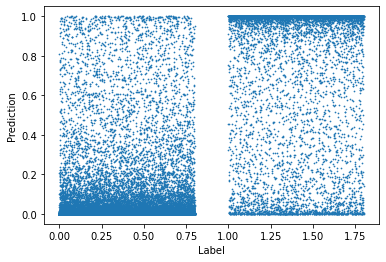

In [108]:
tps = dropout_A_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [109]:
predicted_classes = np.argmax(np.round(test_predictions),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                    precision    recall  f1-score   support

Picoides nuttallii       0.08      0.58      0.13        74
     Egretta thula       0.76      0.58      0.66       521
    Ardea herodias       0.79      0.68      0.73       890
   Spinus psaltria       0.66      0.70      0.68       292
Sitta carolinensis       0.58      0.49      0.53       154
Anas platyrhynchos       0.85      0.86      0.85      1665
Picoides pubescens       0.87      0.69      0.77       296
Turdus migratorius       0.88      0.73      0.80       587
    Megascops asio       0.50      0.61      0.55        23
  Falco sparverius       0.83      0.69      0.75       253
  Zenaida macroura       0.67      0.78      0.72       527
        Ardea alba       0.72      0.66      0.69       702
    Spinus tristis       0.80      0.54      0.65       342
  Sturnus vulgaris       0.71      0.73      0.72       430

          accuracy                           0.72      6756
         macro avg       0.69      0.6

In [110]:
test_predictions = dropout_A_model.predict(test_dataset)
predict_labels = np.argmax(test_predictions, axis=1)

In [111]:
matrix = confusion_matrix(actual_labels,predict_labels)
print('Confusion matrix :''\n''\n', matrix)


Confusion matrix :

 [[  33    0    0    0    3    6   13    4    4    0    2    1    0    8]
 [   0  315   33    2    2   32    1    0    1    3   13  114    1    4]
 [   0   15  634    3   12   90    1    5    4    7   35   53    1   30]
 [   0    1    5  210    3   11    2    6    0    4   11    2   28    9]
 [   2    1   12    5   79    7   11    5    1    1   18    4    3    5]
 [   1    6   38    9   10 1467    6   15    8    7   36   24    6   32]
 [  10    1    7    6   17   13  208    8    1    1    8    0    4   12]
 [   2    0    8    5    6   43    2  442    3    8   30    3    7   28]
 [   0    0    1    0    3    3    0    1   14    0    1    0    0    0]
 [   0    1   11    3    1   15    0    8    0  181   22    3    0    8]
 [   0    3   12    6    5   17    2   14    1    3  425    4    8   27]
 [   0   90   56    4    6   36    1    3    2    2   14  479    0    9]
 [   0    0    5   82    5   16    2    1    2    2   28    1  194    4]
 [   2    0   11    3    3   3

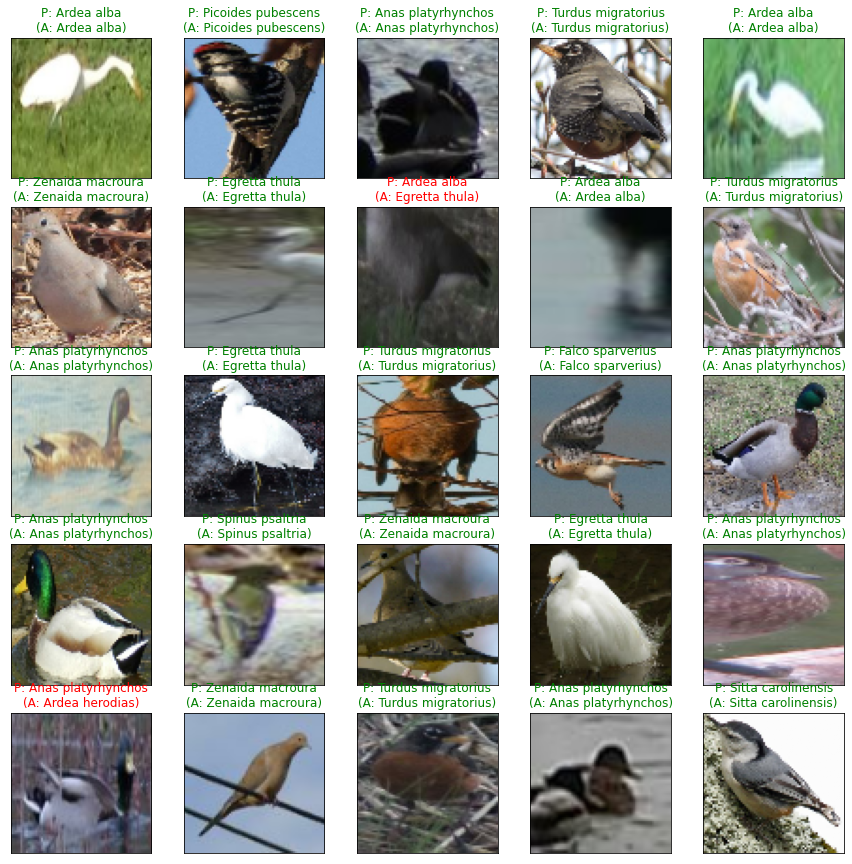

In [112]:
sample_predictions = dropout_A_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

### Applying slower learning rate to reduce overfitting:

#### Training the encoder model:

In [86]:
def normalised_encoder(input_img):

    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    conv4 = BatchNormalization()(x)
    return conv4

def normalised_decoder(conv4):    
    #decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 

    
  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
   

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x) 
    x = Dropout(0.4)(x)
    
    ft = Flatten()(x)
    d = Dense(128, activation='relu')(ft)
    dp4 = Dropout(0.2)(d)
    decoded = Dense(14, activation='softmax')(dp4)
    
    

    return decoded

In [87]:
lr_normalised_autoencoder = Model(input_img, normalised_decoder(normalised_encoder(input_img)))
lr_normalised_autoencoder.compile(loss='mean_squared_error', optimizer ='Adam')

In [88]:
lr_normalised_autoencoder_train = lr_normalised_autoencoder.fit(train_dataset_w, batch_size=BATCH_SIZE,epochs=20,verbose=1,validation_data=(validation_dataset))

Epoch 1/20
364/364 [==============================] - 37s 93ms/step - loss: 0.1325 - val_loss: 0.1333
Epoch 2/20
364/364 [==============================] - 34s 92ms/step - loss: 0.1331 - val_loss: 0.1314
Epoch 3/20
364/364 [==============================] - 34s 91ms/step - loss: 0.1320 - val_loss: 0.1325
Epoch 4/20
364/364 [==============================] - 34s 92ms/step - loss: 0.1329 - val_loss: 0.1347
Epoch 5/20
364/364 [==============================] - 34s 92ms/step - loss: 0.1345 - val_loss: 0.1346
Epoch 6/20
364/364 [==============================] - 34s 91ms/step - loss: 0.1345 - val_loss: 0.1346
Epoch 7/20
364/364 [==============================] - 34s 92ms/step - loss: 0.1344 - val_loss: 0.1346
Epoch 8/20
364/364 [==============================] - 34s 92ms/step - loss: 0.1345 - val_loss: 0.1346
Epoch 9/20
364/364 [==============================] - 35s 94ms/step - loss: 0.1344 - val_loss: 0.1346
Epoch 10/20
364/364 [==============================] - 34s 92ms/step - loss: 0.134

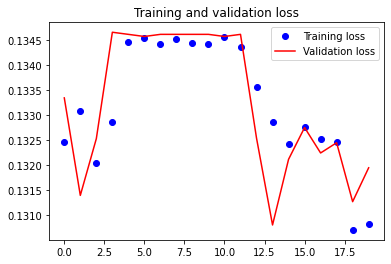

In [89]:
loss = lr_normalised_autoencoder_train.history['loss']
val_loss = lr_normalised_autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [90]:
def normalised_encoder(input_img):
  
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    x = BatchNormalization()(x)
   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
   
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    conv4 = BatchNormalization()(x)
    return conv4

In [91]:

train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

In [92]:

normalised_encode = normalised_encoder(input_img)
slow_rate_full_model = Model(input_img,fc(normalised_encode))

In [93]:
for l1,l2 in zip(slow_rate_full_model.layers[:24],lr_normalised_autoencoder.layers[0:24]):
    l1.set_weights(l2.get_weights())

In [94]:
for layer in slow_rate_full_model.layers[0:24]:
    layer.trainable = False

In [95]:
slow_rate_full_model.compile(loss='categorical_crossentropy', optimizer ='adam',metrics=['accuracy'])

In [96]:
slow_rate_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
slow_rate_full_model_train = slow_rate_full_model.fit(train_dataset_w, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset))



Epoch 1/30
364/364 [==============================] - 14s 35ms/step - loss: 2.6284 - accuracy: 0.0973 - val_loss: 2.5497 - val_accuracy: 0.0950
Epoch 2/30
364/364 [==============================] - 13s 34ms/step - loss: 2.5601 - accuracy: 0.1093 - val_loss: 2.5021 - val_accuracy: 0.1181
Epoch 3/30
364/364 [==============================] - 13s 34ms/step - loss: 2.5315 - accuracy: 0.1119 - val_loss: 2.4839 - val_accuracy: 0.1231
Epoch 4/30
364/364 [==============================] - 13s 34ms/step - loss: 2.5151 - accuracy: 0.1176 - val_loss: 2.4560 - val_accuracy: 0.1226
Epoch 5/30
364/364 [==============================] - 13s 34ms/step - loss: 2.5018 - accuracy: 0.1189 - val_loss: 2.4645 - val_accuracy: 0.1341
Epoch 6/30
364/364 [==============================] - 14s 36ms/step - loss: 2.4916 - accuracy: 0.1273 - val_loss: 2.4696 - val_accuracy: 0.1374
Epoch 7/30
364/364 [==============================] - 13s 34ms/step - loss: 2.4892 - accuracy: 0.1262 - val_loss: 2.4940 - val_accuracy:

In [98]:
for layer in slow_rate_full_model.layers[0:24]:
    layer.trainable = True

In [99]:
def scheduler(epoch, lr):
    return lr * 0.95

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [102]:
slow_rate_full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), # Lower initial learning rate
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [103]:
slow_rate_full_model_train = slow_rate_full_model.fit(train_dataset_w, batch_size=BATCH_SIZE,epochs=30,verbose=1,validation_data=(validation_dataset),callbacks=[lr_callback])

Epoch 1/30
364/364 [==============================] - 19s 48ms/step - loss: 1.9567 - accuracy: 0.2821 - val_loss: 1.9146 - val_accuracy: 0.3289
Epoch 2/30
364/364 [==============================] - 18s 47ms/step - loss: 1.8345 - accuracy: 0.3122 - val_loss: 1.9780 - val_accuracy: 0.3150
Epoch 3/30
364/364 [==============================] - 18s 48ms/step - loss: 1.7311 - accuracy: 0.3464 - val_loss: 1.7826 - val_accuracy: 0.3686
Epoch 4/30
364/364 [==============================] - 18s 47ms/step - loss: 1.6178 - accuracy: 0.3790 - val_loss: 1.6654 - val_accuracy: 0.4124
Epoch 5/30
364/364 [==============================] - 18s 47ms/step - loss: 1.5382 - accuracy: 0.4089 - val_loss: 1.7057 - val_accuracy: 0.4230
Epoch 6/30
364/364 [==============================] - 18s 48ms/step - loss: 1.4582 - accuracy: 0.4349 - val_loss: 1.5776 - val_accuracy: 0.4461
Epoch 7/30
364/364 [==============================] - 18s 47ms/step - loss: 1.3749 - accuracy: 0.4660 - val_loss: 1.5198 - val_accuracy:

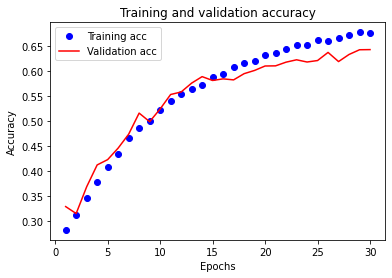

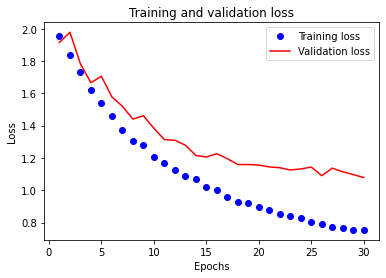

In [104]:
train_acc = slow_rate_full_model_train.history['accuracy']
val_acc = slow_rate_full_model_train.history['val_accuracy']
train_loss = slow_rate_full_model_train.history['loss']
val_loss = slow_rate_full_model_train.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [105]:
slow_rate_full_model.save('AUTOEN_w_slow_rate_filtered_confusing_species.h5')


In [67]:
slow_learning_rate_A_model = tf.keras.models.load_model('AUTOEN_w_slow_rate_filtered_confusing_species.h5')


#### Evaluating the slow learning rate model:

In [74]:
slow_learning_rate_A_model.evaluate(test_dataset, return_dict=True)

104/104 [==============================] - 2s 17ms/step - loss: 1.1526 - accuracy: 0.6218


{'loss': 1.1525509357452393, 'accuracy': 0.6218176484107971}

In [108]:
test_predictions = slow_rate_full_model.predict(test_dataset)
test_predictions.shape
  

(6756, 14)

In [76]:
slow_predicted_classes = slow_learning_rate_A_model.predict(test_dataset)

In [77]:
actual_labels = np.array(list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6756,)

In [78]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()

In [79]:
all_test_labels = np.array([l for _, l in test_dataset.unbatch().as_numpy_iterator()])

In [118]:
predicted_classes = np.argmax(np.round(slow_predicted_classes),axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_classes, target_names=c_names))

                    precision    recall  f1-score   support

Picoides nuttallii       0.03      0.72      0.06        74
     Egretta thula       0.63      0.39      0.48       521
    Ardea herodias       0.73      0.56      0.63       890
   Spinus psaltria       0.74      0.50      0.60       292
Sitta carolinensis       0.43      0.39      0.41       154
Anas platyrhynchos       0.95      0.49      0.65      1665
Picoides pubescens       0.88      0.54      0.67       296
Turdus migratorius       0.85      0.58      0.69       587
    Megascops asio       0.20      0.74      0.32        23
  Falco sparverius       0.64      0.65      0.65       253
  Zenaida macroura       0.58      0.61      0.60       527
        Ardea alba       0.62      0.51      0.56       702
    Spinus tristis       0.73      0.54      0.62       342
  Sturnus vulgaris       0.66      0.69      0.68       430

          accuracy                           0.54      6756
         macro avg       0.62      0.5

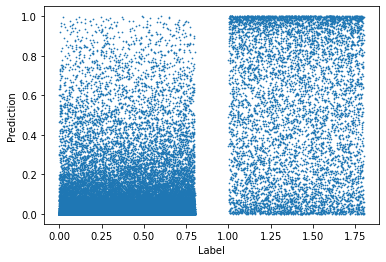

In [69]:
tps = slow_learning_rate_A_model.predict(test_dataset)



plt.scatter(jittered_labels,  tps, s=0.5 )
plt.xlabel('Label')
plt.ylabel('Prediction');

In [ ]:
sample_predictions = slow_learning_rate_A_model(sample_imgs)

# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

# output cleared to reduce notebook size

## EVALUATION OF ALL METHODS FOR THE *Filtered_confusing_species* Dataset

In [119]:
METRICS = [
    lambda : tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
    lambda : tf.keras.metrics.Precision(name='precision'),
    lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

In [120]:
model_dir = os.path.dirname(os.path.realpath("slow_rate_a_model_most_common_not_aves.h5"))
glob.glob(os.path.join(model_dir, '*filtered_confusing_species.h5'))

['/tf/2021J_EMA/AUTOEN_w_slow_rate_filtered_confusing_species.h5',
 '/tf/2021J_EMA/CNN_weighted_reslinks_filtered_confusing_species.h5',
 '/tf/2021J_EMA/CNN_w_agn_norm_filtered_confusing_species.h5',
 '/tf/2021J_EMA/CNN_unbalanced_filtered_confusing_species.h5',
 '/tf/2021J_EMA/CNN_reduced_agn_filtered_confusing_species.h5',
 '/tf/2021J_EMA/AUTOEN_w_drop_filtered_confusing_species.h5',
 '/tf/2021J_EMA/AUTOEN_weighted_base_filtered_confusing_species.h5',
 '/tf/2021J_EMA/CNN_weighted_agn_filtered_confusing_species.h5']

In [121]:
filtered_confusing_species_model_dir = []
for path in sorted(glob.glob(os.path.join(model_dir, '*filtered_confusing_species.h5'))):
    filtered_confusing_species_model_dir.append( {'path': path, 'label': os.path.basename(path)} )


In [122]:
def predictions_from_model(path_to_model, return_metrics=True):
    """Load and evaluate a model, return its predictions and optionally metrics"""
    m = tf.keras.models.load_model(path_to_model)
    if return_metrics:
        m.compile(metrics=fresh_metrics())
        metrics = m.evaluate(validation_dataset, return_dict=True)
    preds = m.predict(test_dataset)
    
    if return_metrics:
        return preds, metrics
    else:
        return preds

In [123]:
# predictions of all models:
for m in filtered_confusing_species_model_dir:
    print(m['label'])
    preds, metrics = predictions_from_model(m['path'], return_metrics=True)
    m['predictions'] = preds
    m['metrics'] = metrics

AUTOEN_w_drop_filtered_confusing_species.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - accuracy: 0.7558 - precision: 0.7858 - recall: 0.7285
AUTOEN_w_slow_rate_filtered_confusing_species.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - accuracy: 0.6436 - precision: 0.7383 - recall: 0.5554
AUTOEN_weighted_base_filtered_confusing_species.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - accuracy: 0.6507 - precision: 0.7008 - recall: 0.6116
CNN_reduced_agn_filtered_confusing_species.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - accuracy: 0.6681 - precision: 0.7286 - recall: 0.6063
CNN_unbalanced_filtered_confusing_species.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.0000e+00 - accuracy: 0.6770 - precision: 0.7466 - recall: 0.6237
CNN_w_agn_norm_filtered_confusing_species.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.0000e+00 - 

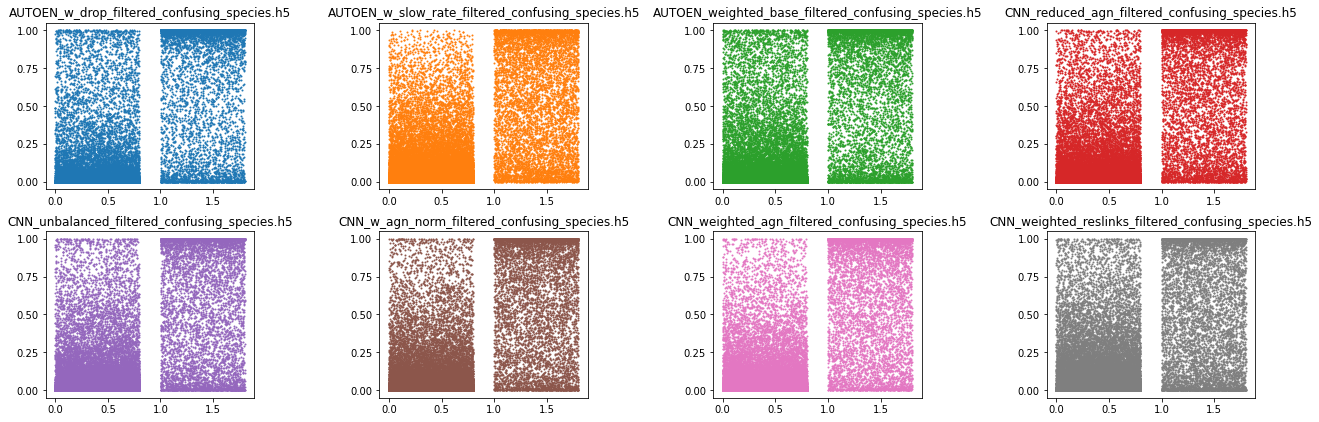

In [124]:
# Scattered plots predictions:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 10))
for i, m in enumerate(filtered_confusing_species_model_dir):
    plt.subplot(4, 4, i+1)
    plt.scatter(jittered_labels, m['predictions'], s=1, color=colors[i % len(colors)])
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.title(m['label'] )
    plt.tight_layout()
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.22, 
                    top=1.2, 
                    wspace=0.6, 
                    hspace=0.25)


# References

  2018. Autoencoder as a Classifier using Fashion-MNIST Dataset Tutorial. [online] Available at: <https://www.datacamp.com/tutorial/autoencoder-classifier-python> [Accessed 15 May 2022].